# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 

## ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende de el tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la cirva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.

  2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.

3. Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.
 
 ## Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

#¡Comencemos!

  A continuación dejamos un ejemplo de cómo extraer el $k$ inicial de Argentina, usando un ajuste de cuadrados mínimos. Si necesitas los datos mundiales, en la columna de países aparecen como "World".



# Librerias y Datos

## Librerias

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
def puntajes(X_test, y_test, y_test_pred, model, plot = True):
  # print("AC SCORE TRAIN:",accuracy_score(y_train, y_train_pred))
  print("AC SCORE:",accuracy_score(y_test, y_test_pred))
  print("F1 SCORE: ", (f1_score(y_test, y_test_pred, average="weighted")))
  if plot == True:
    plot_confusion_matrix(model, X_test, y_test, values_format=".0f") 

def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

def casos_nuevos(casos):
  nuevos=np.zeros(len(casos))
  i=0
  while i<len(nuevos)-1:
    nuevos[i]=casos[i+1]-casos[i]
    i=i+1

  return nuevos

def bootstrap_simplificado(dataset, B=100):
    boots = []
    for _ in range(B):
        boots.append(np.random.choice(dataset, size=len(dataset)))
    return np.array(boots)

## Carga del Datasep

In [3]:
datos=pd.read_csv('owid-covid-data.csv')
print(datos.shape)
datos.head(3).append(datos.tail(3))


(190197, 67)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
190194,ZWE,Africa,Zimbabwe,2022-05-27,251959.0,313.0,212.857,5500.0,2.0,1.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
190195,ZWE,Africa,Zimbabwe,2022-05-28,251959.0,0.0,212.857,5500.0,0.0,1.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
190196,ZWE,Africa,Zimbabwe,2022-05-29,252092.0,133.0,207.143,5500.0,0.0,0.857,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [4]:
data_cuarentena = pd.read_csv("stay-at-home-covid.csv")
print(data_cuarentena.shape)
data_cuarentena.head(3).append(data_cuarentena.tail(3))

(161396, 4)


,Entity,Code,Day,stay_home_requirements
0,Afghanistan,AFG,2020-01-01,0
1,Afghanistan,AFG,2020-01-02,0
2,Afghanistan,AFG,2020-01-03,0
161393,Zimbabwe,ZWE,2022-05-22,2
161394,Zimbabwe,ZWE,2022-05-23,2
161395,Zimbabwe,ZWE,2022-05-24,2


In [5]:
paises_seleccionados = pd.read_csv("paises_seleccionados.csv")
paises_seleccionados.head(3).append(paises_seleccionados.tail(3))


,pais,t0,fecha (t0),total_cases (t0),tf,fecha (tf),total_cases (tf),ventana,Inicio cuarentena,prom stringency_index
0,Australia,34,2020-02-29 00:00:00,25,60,2020-03-26 00:00:00,2810,26,NaN,"31,89 %"
1,Austria,4,2020-02-29 00:00:00,3,25,2020-03-21 00:00:00,2398,21,2020-03-16 00:00:00,"38,05 %"
2,Czechia,0,2020-03-01 00:00:00,3,19,2020-03-20 00:00:00,833,19,2020-03-15 00:00:00,"44,12 %"
7,Switzerland,2,2020-02-27 00:00:00,8,29,2020-03-25 00:00:00,10897,27,NaN,"40,87 %"
8,Thailand,65,2020-03-09 00:00:00,50,81,2020-03-25 00:00:00,934,16,NaN,"38,51 %"
9,United Kingdom,26,2020-02-26 00:00:00,37,55,2020-03-26 00:00:00,20870,29,2020-03-22 00:00:00,"26,06 %"


# Primera parte: ¿Cómo empezó la pandemia?

### a. Explora la fuente de datos: 

¿que representa el dataset? 

El dataset contiene una colección de los datos de COVID-19 mantenidos por Our World in Data.

Donde se Incluyen los siguientes datos:

| Métricas | Fuente | Actualizado | Países |
| --- | --- | --- | --- |
| Vacunas |	Datos oficiales recopilados por el equipo de Our World in Data | Diario | 218 |
| Pruebas y positividad | Datos oficiales recopilados por el equipo de Our World in Data | Semanal | 193 |
| Hospital y UCI | Datos oficiales recopilados por el equipo de Our World in Data |	Diario |	47 |
| Casos confirmados| Datos de JHU CSSE COVID-19 | Diario | 217 |
|Muertes confirmadas	|Datos de JHU CSSE COVID-19	|Diario	|217|
|Tasa de reproducción|	Arroyo-Marioli F, Bullano F, Kucinskas S, Rondón-Moreno C|	Diario|	192|
|Respuestas de política|	Rastreador de respuesta gubernamental COVID-19 de Oxford|	Diario|	187|
|Otras variables de interés|	Organismos internacionales (ONU, Banco Mundial, OCDE, IHME...)|	Fijo|	241|


¿hay informacion sobre las columnas?

Si, en la fuente de datos se puede encontrar la descipcion de cada unas de las columnas del dataset.


### b. Realiza un analisis exploratorio que incluya:

In [6]:
datos.head(2).append(datos.tail(2))

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
190195,ZWE,Africa,Zimbabwe,2022-05-28,251959.0,0.0,212.857,5500.0,0.0,1.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
190196,ZWE,Africa,Zimbabwe,2022-05-29,252092.0,133.0,207.143,5500.0,0.0,0.857,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [7]:
print(datos.shape)

(190197, 67)


In [8]:
var_num = []
var_cat = []

for i in datos.columns:
  if datos.dtypes[i] != "object":
    var_num.append(i)
  else :
    var_cat.append(i)

print(f"Variables de tipo categoricas: {len(var_cat)}")
print(var_cat,"\n")

print(f"Variables de tipo numericas: {len(var_num)}")
print(var_num)

Variables de tipo categoricas: 5
['iso_code', 'continent', 'location', 'date', 'tests_units'] 

Variables de tipo numericas: 62
['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vac

In [9]:
datos.isna().sum().sort_values(ascending=False).head(30)

weekly_icu_admissions_per_million          184018
weekly_icu_admissions                      184018
excess_mortality_cumulative_per_million    183672
excess_mortality                           183672
excess_mortality_cumulative                183672
excess_mortality_cumulative_absolute       183672
weekly_hosp_admissions_per_million         177886
weekly_hosp_admissions                     177886
total_boosters                             166166
total_boosters_per_hundred                 166166
icu_patients_per_million                   164863
icu_patients                               164863
hosp_patients_per_million                  163600
hosp_patients                              163600
new_vaccinations                           147648
people_fully_vaccinated                    143262
people_fully_vaccinated_per_hundred        143262
people_vaccinated_per_hundred              140722
people_vaccinated                          140722
total_vaccinations_per_hundred             138265


In [10]:
datos.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,1.826890e+05,1.823980e+05,1.812240e+05,1.642530e+05,164218.000000,163055.000000,181846.000000,181555.000000,180386.000000,163423.000000,...,118538.000000,116913.000000,77002.000000,139059.000000,177872.000000,152676.000000,6.525000e+03,6525.000000,6525.000000,6525.000000
mean,3.255675e+06,1.235991e+04,1.240611e+04,6.440761e+04,158.804467,159.790856,40831.940993,185.739235,186.038944,584.265971,...,10.644249,32.791522,50.927890,3.068694,73.650089,0.725232,4.078743e+04,9.766654,15.598670,1114.211895
std,2.043864e+07,8.743905e+04,8.591457e+04,3.357283e+05,792.757451,776.238630,75944.597328,949.045816,618.836875,869.344116,...,10.581242,13.529305,31.857361,2.519921,7.449731,0.149733,1.132332e+05,16.036976,28.984741,1561.732319
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000,0.000000,0.001000,0.000000,0.000000,0.000000,...,0.100000,7.700000,1.188000,0.100000,53.280000,0.394000,-3.772610e+04,-28.450000,-95.920000,-1826.595723
25%,2.646000e+03,0.000000e+00,6.714000e+00,9.300000e+01,0.000000,0.143000,778.487750,0.000000,1.505000,23.097500,...,1.900000,21.600000,20.859000,1.300000,69.500000,0.602000,-1.460000e+01,-0.170000,-0.300000,-7.321200
50%,3.504300e+04,7.100000e+01,1.011430e+02,9.100000e+02,1.000000,2.143000,6328.986000,10.340000,19.114500,164.330000,...,6.300000,31.400000,49.839000,2.400000,75.050000,0.743000,4.237200e+03,6.560000,7.440000,569.657043
75%,3.755540e+05,1.032750e+03,1.141465e+03,8.394000e+03,18.000000,19.429000,50769.369000,101.973000,128.660750,839.813000,...,19.300000,41.300000,83.241000,4.000000,79.070000,0.845000,2.783340e+04,14.680000,21.880000,1784.551578
max,5.289963e+08,4.079827e+06,3.437214e+06,6.287786e+06,18151.000000,14795.286000,706541.904000,208049.887000,37617.428000,6390.190000,...,44.000000,78.100000,100.000000,13.800000,86.750000,0.957000,1.213593e+06,111.010000,375.000000,9725.192865


In [11]:
len(datos['location'].unique())

244

In [12]:
paises=datos['location'] #cargo el vector de paises
confirmados=datos['total_cases'] #carga vector todos los casos confirmados
paises_fecha = pd.to_datetime(datos.date)

### Justificar
Seleccionamos los siguientes países:
Para seleccionar me base en:
- El crecimiento del total de casos dentro de la ventana tenga un comportamiento exponencial.
- la ventana sea mayor a 2 semanas.
- la cantidad de casos en **t0** sea mayor que 0.
- la fecha de **t0** sea anterior al 15/03/2020.
- no se haya aplicado cuarentena dentro de la ventana, y de tenerla que su inicio sea lo más cercana posible al cierre de la ventana, así afectaba lo menos posible el valor de K.
- Que sean países de Europa o Asia, a diferencia de Australia que es de Oceanía, pero se encuentra cerca de china. 

Nota: para analizar los tatos y realizar la selección me apoye de la herramienta de **PowerBi**, se puede observar en el siguiente link:

https://app.powerbi.com/view?r=eyJrIjoiZDg5ZmUyMTMtNmY5MS00OWUyLThlYTctMzMyMGMwNDY5YjdmIiwidCI6IjI5MzRjMDhjLWVmNzEtNDFmNy1hYzk1LTY1YjU0NjZmYjE5YSIsImMiOjR9&pageName=ReportSection


In [13]:
paises_seleccionados

,pais,t0,fecha (t0),total_cases (t0),tf,fecha (tf),total_cases (tf),ventana,Inicio cuarentena,prom stringency_index
0,Australia,34,2020-02-29 00:00:00,25,60,2020-03-26 00:00:00,2810,26,NaN,"31,89 %"
1,Austria,4,2020-02-29 00:00:00,3,25,2020-03-21 00:00:00,2398,21,2020-03-16 00:00:00,"38,05 %"
2,Czechia,0,2020-03-01 00:00:00,3,19,2020-03-20 00:00:00,833,19,2020-03-15 00:00:00,"44,12 %"
3,Finland,26,2020-02-24 00:00:00,3,51,2020-03-20 00:00:00,649,25,NaN,"30,38 %"
4,Germany,30,2020-02-26 00:00:00,21,55,2020-03-22 00:00:00,18610,25,2020-03-21 00:00:00,"34,54 %"
5,Pakistan,2,2020-02-27 00:00:00,2,26,2020-03-22 00:00:00,875,24,NaN,"38,55 %"
6,Portugal,2,2020-03-03 00:00:00,2,29,2020-03-30 00:00:00,6408,27,2020-03-19 00:00:00,"52,71 %"
7,Switzerland,2,2020-02-27 00:00:00,8,29,2020-03-25 00:00:00,10897,27,NaN,"40,87 %"
8,Thailand,65,2020-03-09 00:00:00,50,81,2020-03-25 00:00:00,934,16,NaN,"38,51 %"
9,United Kingdom,26,2020-02-26 00:00:00,37,55,2020-03-26 00:00:00,20870,29,2020-03-22 00:00:00,"26,06 %"


In [14]:
data_p = paises_seleccionados[["pais","t0","tf"]]
data_p

,pais,t0,tf
0,Australia,34,60
1,Austria,4,25
2,Czechia,0,19
3,Finland,26,51
4,Germany,30,55
5,Pakistan,2,26
6,Portugal,2,29
7,Switzerland,2,29
8,Thailand,65,81
9,United Kingdom,26,55


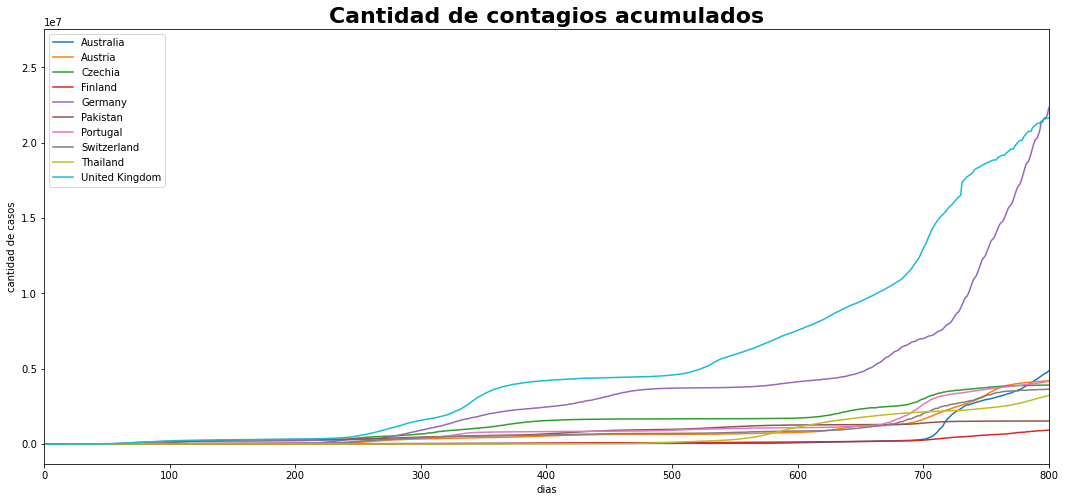

In [15]:
plt.figure(figsize=(18,8))
for i in data_p["pais"].to_numpy():

  lista = []
  ind = np.where(paises==i)
  ind = ind[0]
  casos = confirmados[ind]
  dias = np.arange(0,len(casos))
  plt.title("Cantidad de contagios acumulados", fontsize=22, fontweight ="bold")
  plt.plot(dias,casos, label=i)
  plt.xlabel('dias')
  plt.ylabel('cantidad de casos')
  plt.legend(loc=0)
  plt.xlim(0,800)

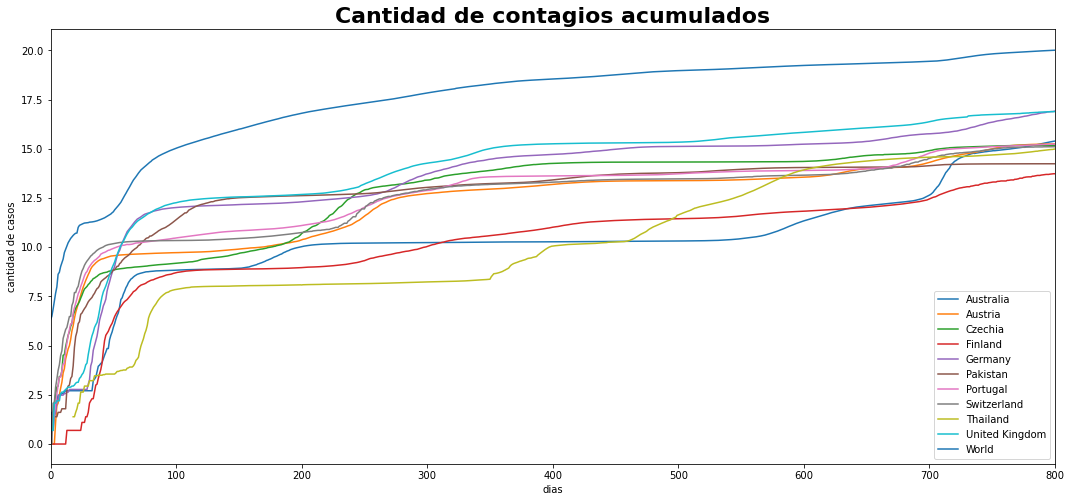

In [16]:
plt.figure(figsize=(18,8))
for i in data_p["pais"].tolist() + ["World"]:

  lista = []
  ind = np.where(paises==i)
  ind = ind[0]
  casos = confirmados[ind]
  dias = np.arange(0,len(casos))
  plt.title("Cantidad de contagios acumulados", fontsize=22, fontweight ="bold")
  plt.plot(dias,np.log(casos), label=i)
  plt.xlabel('dias')
  plt.ylabel('cantidad de casos')
  plt.legend(loc=0)
  plt.xlim(0,800)

(0.0, 500000.0)

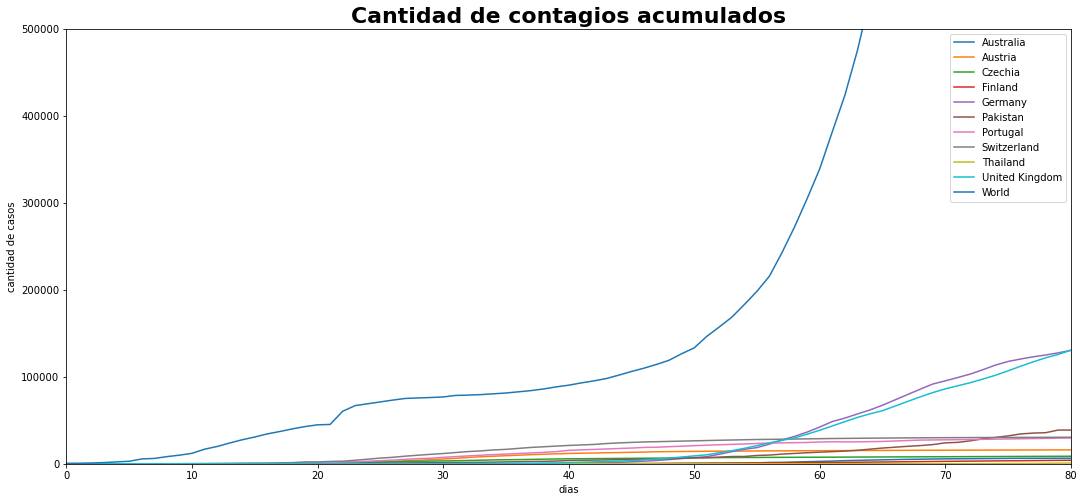

In [17]:
plt.figure(figsize=(18,8))


for i in data_p["pais"].tolist() + ["World"]:

  lista = []
  ind = np.where(paises==i)
  ind = ind[0]
  casos = confirmados[ind]
  dias = np.arange(0,len(casos))
  plt.title("Cantidad de contagios acumulados", fontsize=22, fontweight ="bold")
  plt.plot(dias,casos, label=i)
  plt.xlabel('dias')
  plt.ylabel('cantidad de casos')
  plt.legend(loc=0)


plt.xlim(0,80)
plt.ylim(0,500000)

(0.0, 15.0)

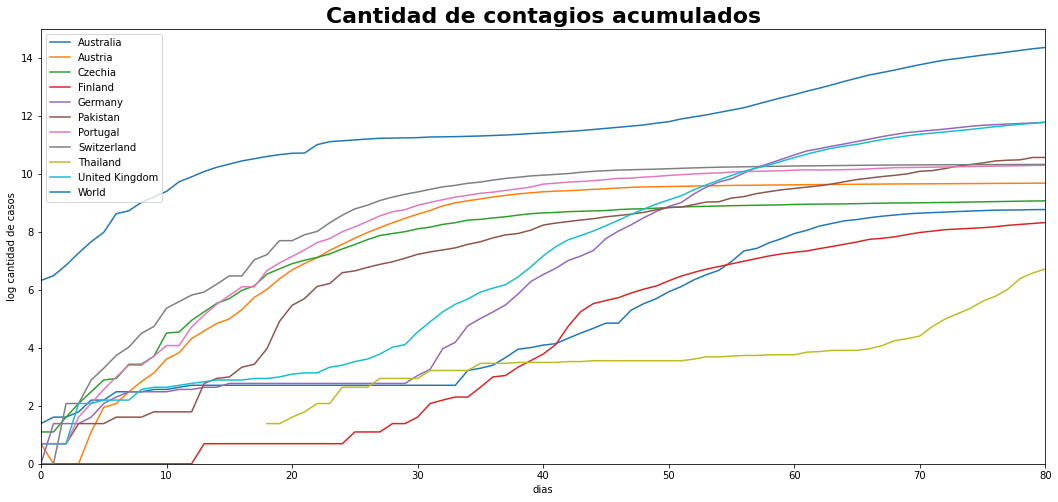

In [18]:
plt.figure(figsize=(18,8))

for i in data_p["pais"].tolist() + ["World"]:

  lista = []
  ind = np.where(paises==i)
  ind = ind[0]
  casos = confirmados[ind]
  dias = np.arange(0,len(casos))
  plt.title("Cantidad de contagios acumulados", fontsize=22, fontweight ="bold")
  plt.plot(dias,np.log(casos), label=i)
  plt.xlabel('dias')
  plt.ylabel('log cantidad de casos')
  plt.legend(loc=0)

plt.xlim(0,80)
plt.ylim(0,15)

In [19]:
def info_pais (pais, t0, tf):

    ind=np.where(paises==pais)
    ind=ind[0]
    casos=confirmados[ind]
    dias=np.arange(0,len(casos))

    casos_principio=casos[t0:tf]
    dias_principio=dias[t0:tf]

    #ajustamos ---- scipy.optimize.curve_fit(f, xdata, ydata)
    popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)

    k=popt[0]
    t0_=popt[1]
    casos_simu=exponencial(dias_principio,k,t0_)

    dic = {"Pais": pais , "t0":[t0], "t":[tf], "k": [k]}
    datos_pais = pd.DataFrame(data=dic)
    return datos_pais

In [20]:
def graf_pais (pais, t0, tf):

    ind=np.where(paises==pais)
    ind=ind[0]
    casos=confirmados[ind]
    dias=np.arange(0,len(casos))

    casos_principio=casos[t0:tf]
    dias_principio=dias[t0:tf]

    #ajustamos ---- scipy.optimize.curve_fit(f, xdata, ydata)
    popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)

    k=popt[0]
    t0_=popt[1]
    casos_simu=exponencial(dias_principio,k,t0_)

    dic = {"Pais": pais , "t0":[t0], "t":[tf], "k": [k]}
    datos_pais = pd.DataFrame(data=dic)

    
    plt.figure(figsize=(20,5))
    plt.suptitle(pais, fontsize=22, fontweight="bold")
    

    plt.subplot(1,3,1)
    plt.plot(dias_principio,casos_principio)
    plt.title("Curva de contagio")
    plt.xlabel('dias')
    plt.ylabel('cantidad de casos')

    plt.subplot(1,3,2)
    plt.plot(dias_principio,np.log(casos_principio))
    plt.title("Logaritmo de la curva de contagio")
    plt.xlabel('dias')
    plt.ylabel('log cantidad de casos')

    plt.subplot(1,3,3)
    plt.title("Prediccion del modelo")
    plt.plot(dias_principio,casos_principio,'.')
    plt.plot(dias_principio,casos_simu)
    plt.xlabel('dias')
    plt.ylabel('cantidad de casos')
    
    plt.tight_layout()

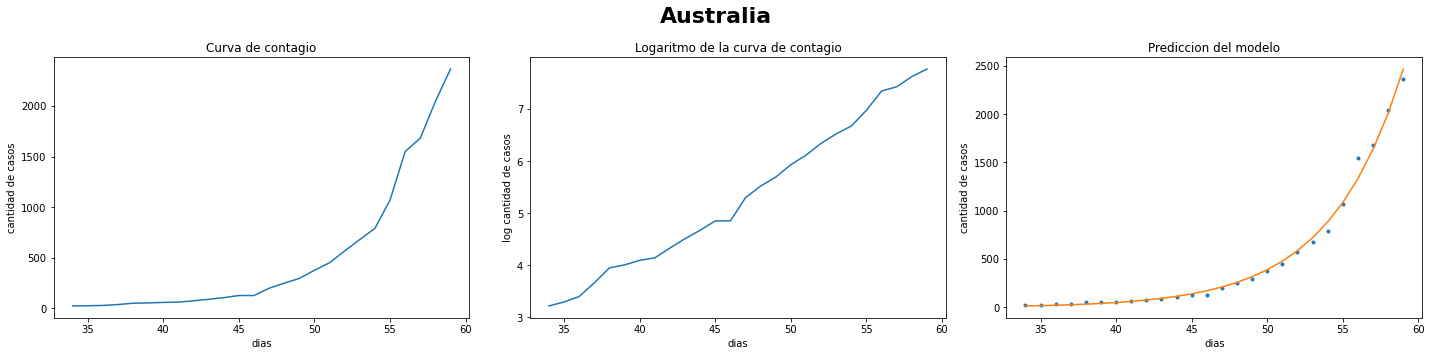

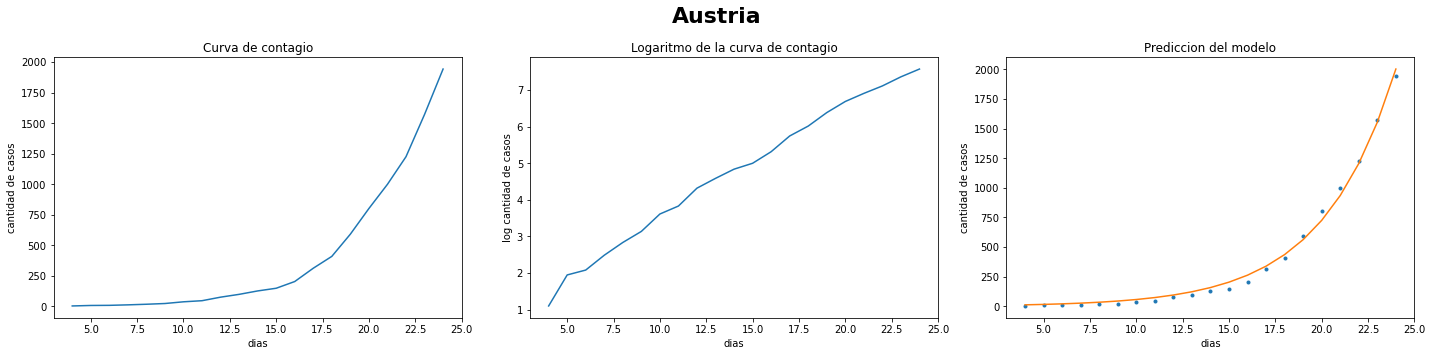

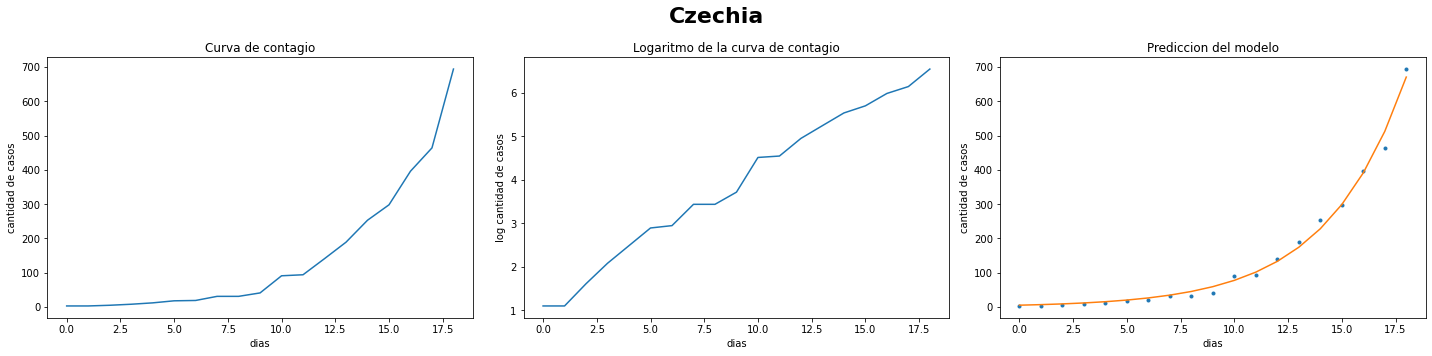

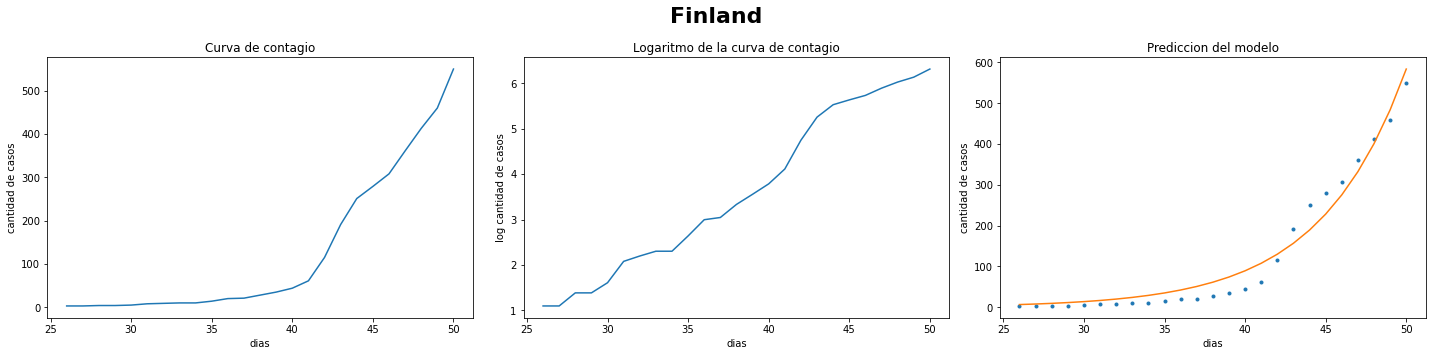

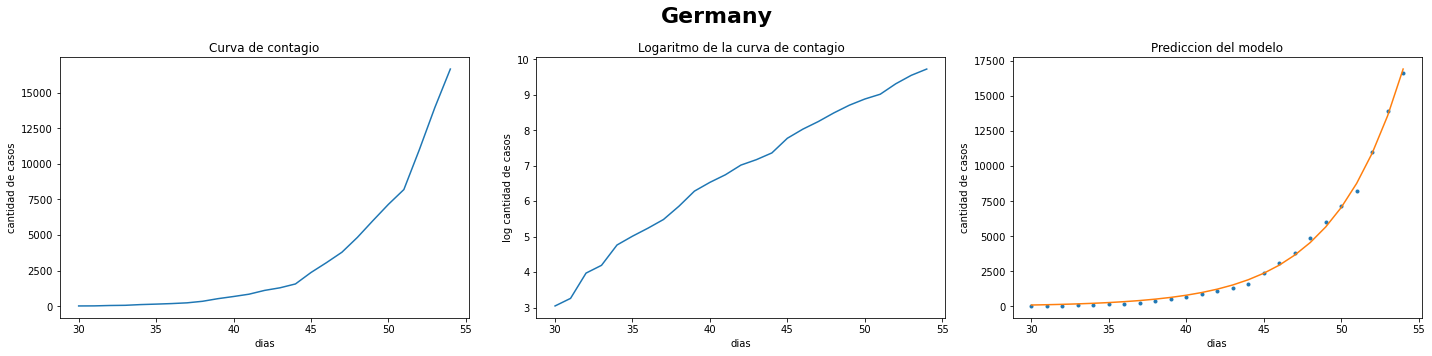

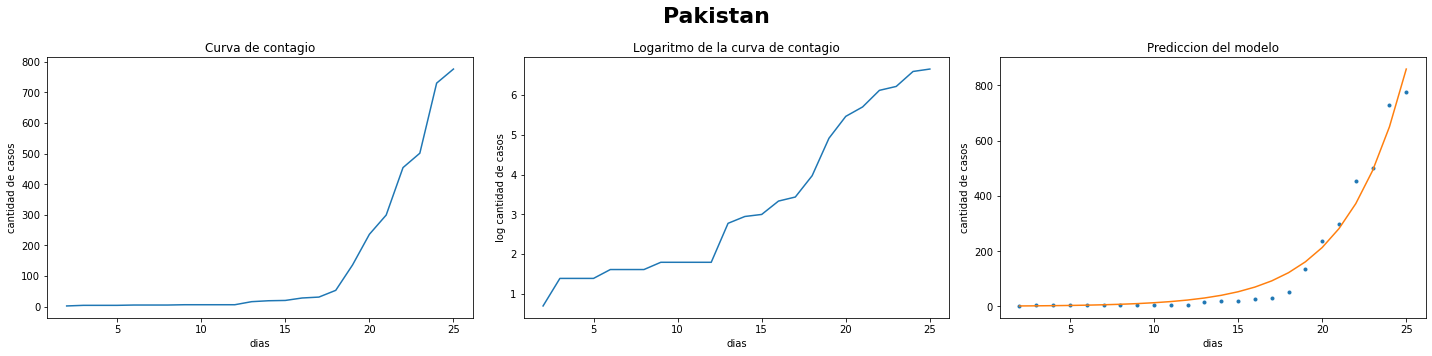

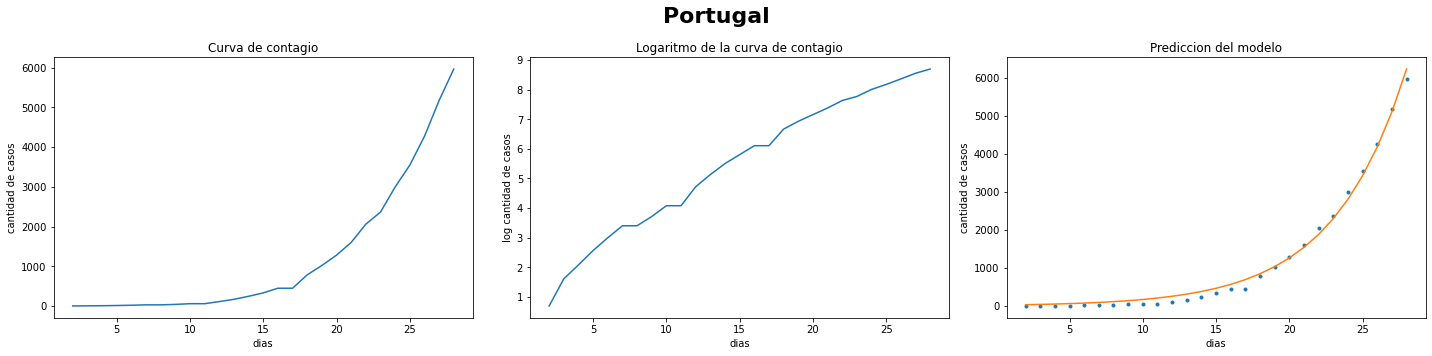

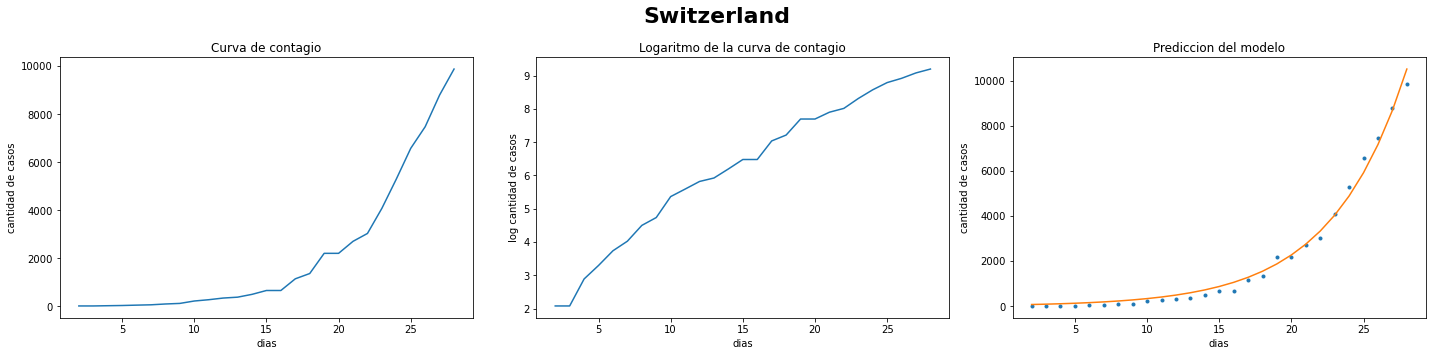

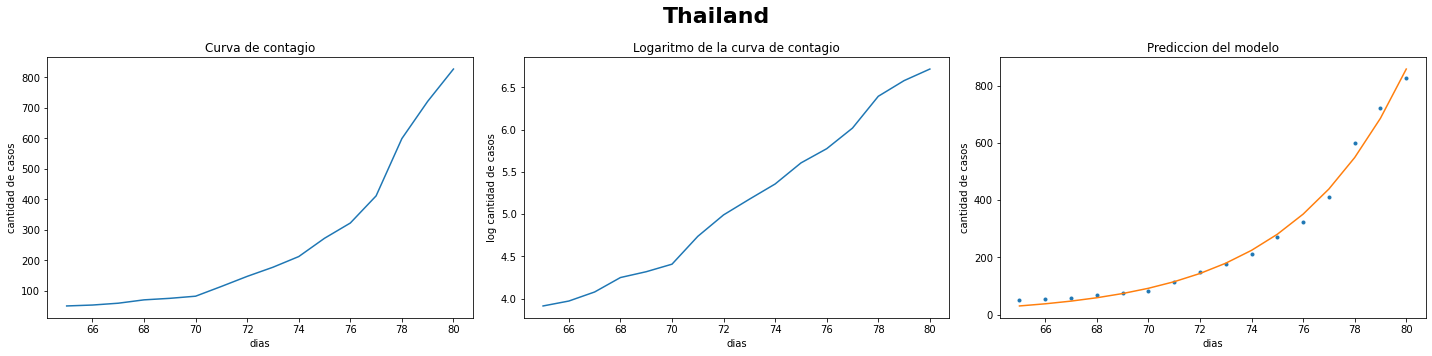

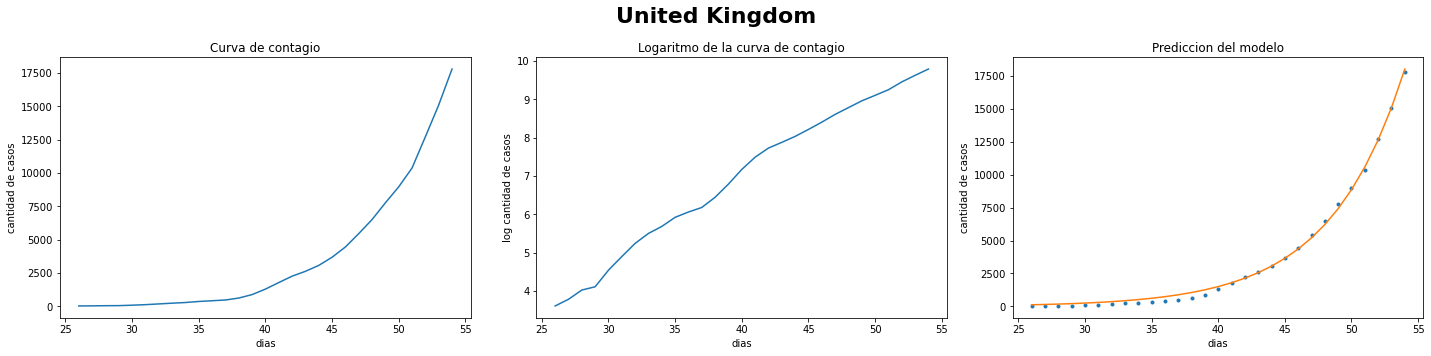

In [21]:
for i in range(len(data_p)):
    graf_pais(data_p.iloc[i].pais, data_p.iloc[i].t0, data_p.iloc[i].tf)

In [22]:
list = []

for i in range(len(data_p)):

    df = info_pais(data_p.iloc[i].pais, data_p.iloc[i].t0, data_p.iloc[i].tf)
    list.append(df)

df_f = pd.concat(list)
df_f

,Pais,t0,t,k
0,Australia,34,60,0.205021
0,Austria,4,25,0.253838
0,Czechia,0,19,0.269519
0,Finland,26,51,0.187865
0,Germany,30,55,0.219179
0,Pakistan,2,26,0.278986
0,Portugal,2,29,0.199389
0,Switzerland,2,29,0.191601
0,Thailand,65,81,0.223539
0,United Kingdom,26,55,0.177342


In [23]:
val_k = df_f.k

In [24]:
# Obtenemos valores estadisticos

print(f"Media de k: { val_k.mean() }")
print(f"Mediana de k: { val_k.median() }")
print(f"Desvio estandar de k: { val_k.std() }")

Media de k: 0.2206279345540194
Mediana de k: 0.21210025898161605
Desvio estandar de k: 0.03558051612954754


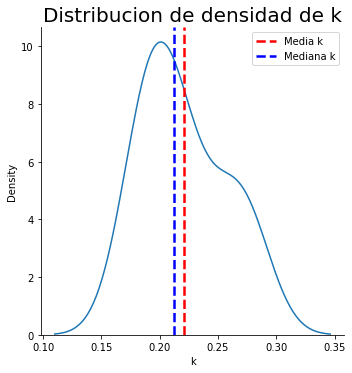

In [25]:
sns.displot(val_k, kind="kde")

plt.title("Distribucion de densidad de k", fontsize=20)
plt.axvline(x=val_k.mean(),
            color='red',
            ls='--',  
            lw=2.5,label ="Media k")  
plt.axvline(x=val_k.median(),
            color='blue',
            ls='--',  
            lw=2.5,label ="Mediana k") 

plt.legend(loc=0)          

k_final=0.22069526866036632


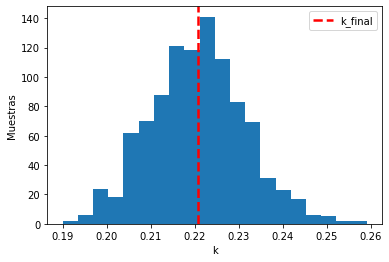

In [26]:
# Bootstrapping

datos_boots = bootstrap_simplificado(val_k,1000)
alpha = 1
medias = np.apply_along_axis(func1d=np.mean, axis=1, arr=datos_boots)
medias.sort()
k_final = medias.mean()
print(f"k_final={medias.mean()}")
plt.hist(medias, bins=20)
plt.axvline(x=k_final,
            color='red',
            ls='--',  
            lw=2.5,label ="k_final")
plt.xlabel("k")
plt.ylabel("Muestras")
plt.legend(loc=0) 


In [27]:
# Construccion del intervalo de confianza
inferior = np.percentile(medias, alpha/2)
superior = np.percentile(medias, (100-alpha/2))
intervalo_confianza = [inferior, superior]
print(f"Con una certeza del 95% el valor del k promedio, al inicio de la pandemia, se encuentra en el intervalo: {intervalo_confianza}")

Con una certeza del 95% el valor del k promedio, al inicio de la pandemia, se encuentra en el intervalo: [0.1957473012238599, 0.24996296131999488]


#### Mundial

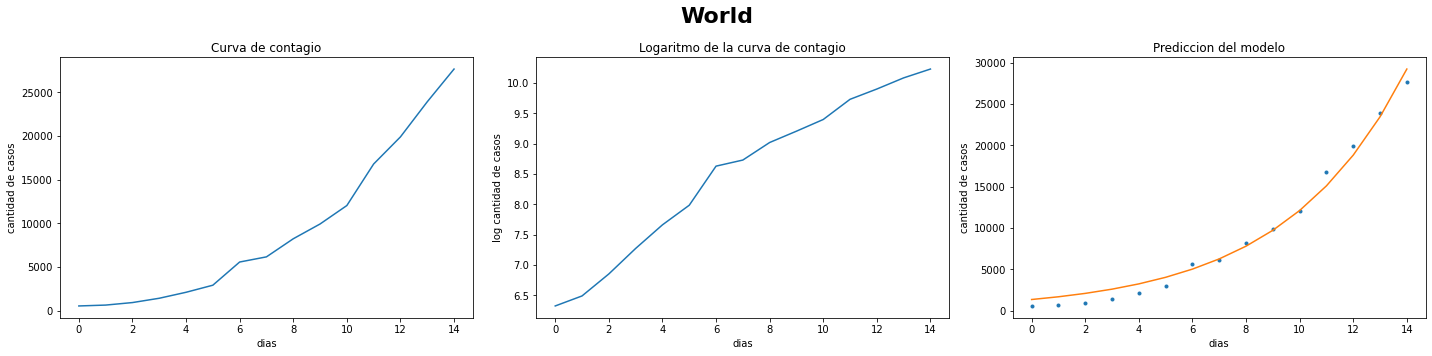

In [28]:
graf_pais("World", 0, 15)

In [29]:
world = info_pais("World", 0, 15)

9254.133333333333

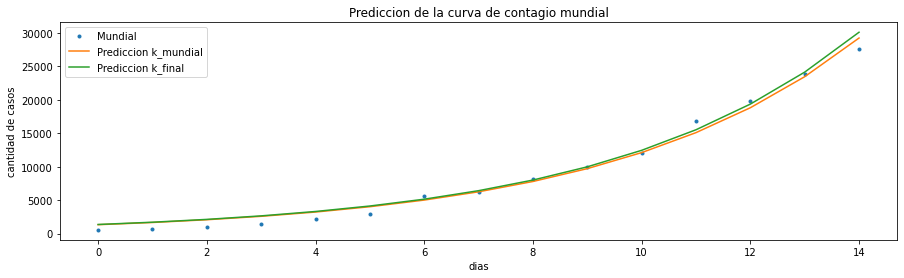

In [30]:
# Probamos el k promedio que habiamos calculado para predecir el comportamiento de la curva de contagio mundial.

ind_world=np.where(paises=='World')
ind_world=ind_world[0]
casos_world=confirmados[ind_world]
casos_principio=casos_world[0:15]
dias_principio=dias[0:15]
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)


k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)


def exponencialK(t,t0):
  C=np.exp(0.2200609287875769*(t-t0))
  return C

popt, pcov = curve_fit(exponencialK, dias_principio, casos_principio)  

# k=popt[0]
t0=popt[0]

casos_simu2=exponencial(dias_principio,k_final,t0)

plt.figure(figsize=(15,4))
plt.plot(dias_principio,casos_principio,'.', label="Mundial")
plt.plot(dias_principio,casos_simu, label="Prediccion k_mundial")
plt.plot(dias_principio,casos_simu2, label="Prediccion k_final")
plt.title("Prediccion de la curva de contagio mundial")
plt.xlabel('dias') 
plt.ylabel('cantidad de casos')
plt.legend()
casos_principio.mean()

In [31]:
# RMSE
rmse = np.sqrt(mean_squared_error(casos_principio, casos_simu2))
print(np.round(rmse,2))

1032.43


valor de k_inicial/k_world:  0.2200 / 0.2203
Diferencia: [-0.00039189]


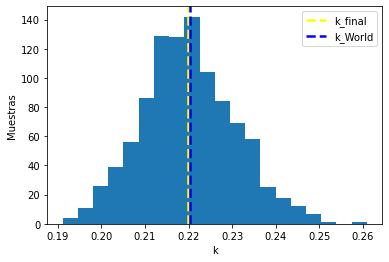

In [32]:
datos_boots = bootstrap_simplificado(val_k,1000)
alpha = 1
medias = np.apply_along_axis(func1d=np.mean, axis=1, arr=datos_boots)
medias.sort()
k_final = medias.mean()
k_world = world["k"].values
plt.hist(medias, bins=20)
plt.axvline(x=k_final,
            color='yellow',
            ls='--',  
            lw=2.5,label ="k_final")
plt.axvline(x=k_world,
            color='blue',
            ls='--',  
            lw=2.5,label ="k_World")
plt.xlabel("k")
plt.ylabel("Muestras")
plt.legend(loc=0) 

print(f"valor de k_inicial/k_world:  %.4f / %.4f" % (k_final,k_world))
print(f"Diferencia: { k_final- k_world}")

### Conclusion

Se puede observar que que el valor de K_final, optenido de los 10 paises seleccionados, da muy similar al valor de k_mundial, aunque estos valores no se pueden considerar concluyentes si bien la infecciosidad del virus es la misma, las formas de propagarse van a variar mucho en los diferentes paises, como tambien las fechas en las que el virus comenzo a propagarse. Esto indica que para poder predecir con una precision considerable la cantidad de contagios hay que tener en cuenta la poblacion de paises bajo las mismas politicas publicas contra el virus. Estas medidas pueden ser uso de mascarilla, hacer cuarentena, vacunaciones, etc.

# Segunda parte: Evaluando estrategias

### Medida

La medida sanitaria elegida es la cuarentena, ya que consideró que una de las medidas más influyentes al momento de reducir el valor de k.

In [33]:
data_cuarentena = pd.read_csv("stay-at-home-covid.csv")
data_cuarentena.Day = pd.to_datetime(data_cuarentena.Day)
data_cuarentena.stay_home_requirements.replace(1,0, inplace=True)
data_cuarentena.stay_home_requirements.replace([3,2],1, inplace=True)

In [34]:
data_cuarentena

,Entity,Code,Day,stay_home_requirements
0,Afghanistan,AFG,2020-01-01,0
1,Afghanistan,AFG,2020-01-02,0
2,Afghanistan,AFG,2020-01-03,0
3,Afghanistan,AFG,2020-01-04,0
4,Afghanistan,AFG,2020-01-05,0
...,...,...,...,...
161391,Zimbabwe,ZWE,2022-05-20,1
161392,Zimbabwe,ZWE,2022-05-21,1
161393,Zimbabwe,ZWE,2022-05-22,1
161394,Zimbabwe,ZWE,2022-05-23,1


### Selección de países

Países que SI hicieron cuarentena en los primeros meses de la pandemia:

* Argentina
* Philippines
* France
* Ecuador
* Lebanon

Países que NO hicieron cuarentena:
* Belarus
* Armenia
* Costa Rica
* Denmark
* Finland

Nota: para seleccionar los países utilice el mismo tablero de **PowerBi**:

https://app.powerbi.com/view?r=eyJrIjoiZDg5ZmUyMTMtNmY5MS00OWUyLThlYTctMzMyMGMwNDY5YjdmIiwidCI6IjI5MzRjMDhjLWVmNzEtNDFmNy1hYzk1LTY1YjU0NjZmYjE5YSIsImMiOjR9&pageName=ReportSection



In [35]:
# sel2_paises = ["Argentina","Mexico","China","India","Italy", "Sweden","Iran","Ukraine", "Niger", "Brazil"]
# sel2_paises = ["Argentina","Mexico","China","India","Italy", "United States","Iran","Ukraine", "Niger", "Brazil"]
sel2_paises = ["Argentina","Philippines","France","Ecuador","Lebanon", 
            "Belarus","Armenia","Costa Rica", "Denmark", "Finland"]

sel3paises = ["India","Chile","Germany","Sweden","Mexico",
        "Russia","Thailand","Kazakhstan","Australia","Ukraine"]


### Indicadores


**new_cases_smoothed_per_million** = Nuevos casos de COVID-19 (Media movil de 7 dias) por 1,000,000 habitantes. El contado incluye casos probables cuando son reportados.

**reproduction_rate** = Estimación en tiempo real del R (factor de reproduccion) efectivo del COVID-19

**stringency_index** = Indice de Rigurosidad de la Respuesta del Gobierno: es una medida compuesta basada en 9 indicadores que incluyen: cierres de escuelas, cierres de espacios de trabajo, prohibicion del transporte publico, etc. Esta reescalado a un valor entre 0 y 100, siendo 100 el valor de mas estricto. 

### Dataframe

In [36]:
datos_paises = datos[(datos.location.isin(sel2_paises)) & (datos.date < "2022-05-01")]
datos_paises = datos[datos.location.isin(sel2_paises)]

datos_paises = datos_paises[["location","date","total_cases","new_cases_smoothed","people_fully_vaccinated","population" ,"reproduction_rate","stringency_index"]]

datos_paises.date = pd.to_datetime(datos_paises.date)
datos_paises

,location,date,total_cases,new_cases_smoothed,people_fully_vaccinated,population,reproduction_rate,stringency_index
6534,Argentina,2020-01-01,NaN,NaN,NaN,45605823.0,NaN,0.0
6535,Argentina,2020-01-02,NaN,NaN,NaN,45605823.0,NaN,0.0
6536,Argentina,2020-01-03,NaN,NaN,NaN,45605823.0,NaN,0.0
6537,Argentina,2020-01-04,NaN,NaN,NaN,45605823.0,NaN,0.0
6538,Argentina,2020-01-05,NaN,NaN,NaN,45605823.0,NaN,0.0
...,...,...,...,...,...,...,...,...
137189,Philippines,2022-05-25,3689457.0,193.857,NaN,111046910.0,NaN,NaN
137190,Philippines,2022-05-26,3689656.0,194.429,NaN,111046910.0,NaN,NaN
137191,Philippines,2022-05-27,3689865.0,193.857,70754670.0,111046910.0,NaN,NaN
137192,Philippines,2022-05-28,3690055.0,186.286,NaN,111046910.0,NaN,NaN


In [37]:
# datos_paises["%new case"] = datos_paises["new_cases_smoothed"] /datos_paises["total_cases"]
# datos_paises["%vaccinated"] = datos_paises["people_fully_vaccinated"] /datos_paises["population"]

In [38]:
datos_paises.drop(columns=["total_cases","people_fully_vaccinated","population"], inplace=True)


# datos_paises.drop(columns=["new_cases_smoothed","total_cases","people_fully_vaccinated","population"], inplace=True)


In [39]:
datos_paises

,location,date,new_cases_smoothed,reproduction_rate,stringency_index
6534,Argentina,2020-01-01,NaN,NaN,0.0
6535,Argentina,2020-01-02,NaN,NaN,0.0
6536,Argentina,2020-01-03,NaN,NaN,0.0
6537,Argentina,2020-01-04,NaN,NaN,0.0
6538,Argentina,2020-01-05,NaN,NaN,0.0
...,...,...,...,...,...
137189,Philippines,2022-05-25,193.857,NaN,NaN
137190,Philippines,2022-05-26,194.429,NaN,NaN
137191,Philippines,2022-05-27,193.857,NaN,NaN
137192,Philippines,2022-05-28,186.286,NaN,NaN


### Correlacion

Text(0.5, 1.0, 'Correlacion entre los indicadores')

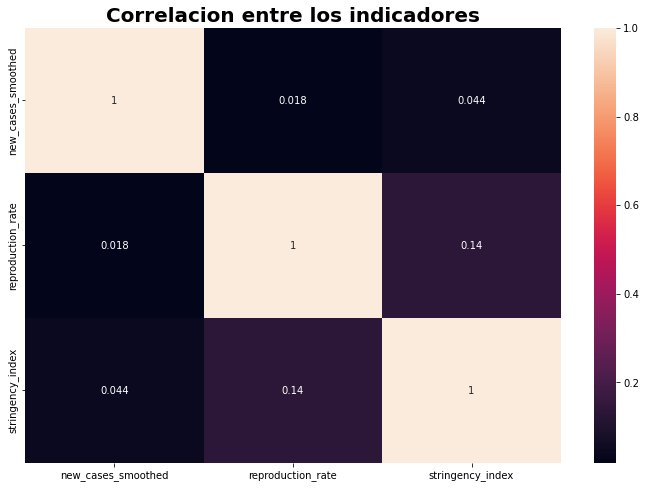

In [40]:
# Analisis de Correlacion entre los indicadores 

corr_df = datos_paises.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_df, annot=True)
plt.title("Correlacion entre los indicadores", fontsize=20, fontweight="bold")

### Ejemplo Argentina

In [41]:
cuaren_arg = data_cuarentena[(data_cuarentena.Entity == "Argentina")&(data_cuarentena.Day <= "2022-05-19")&(data_cuarentena.Day >= "2020-03-03")]
cuaren_arg.set_index("Day", inplace=True)

In [42]:
cuaren_arg

,Entity,Code,stay_home_requirements
Day,,,
2020-03-03,Argentina,ARG,0
2020-03-04,Argentina,ARG,0
2020-03-05,Argentina,ARG,0
2020-03-06,Argentina,ARG,0
2020-03-07,Argentina,ARG,0
...,...,...,...
2022-05-15,Argentina,ARG,0
2022-05-16,Argentina,ARG,0
2022-05-17,Argentina,ARG,0


In [43]:
data_cuarentena

,Entity,Code,Day,stay_home_requirements
0,Afghanistan,AFG,2020-01-01,0
1,Afghanistan,AFG,2020-01-02,0
2,Afghanistan,AFG,2020-01-03,0
3,Afghanistan,AFG,2020-01-04,0
4,Afghanistan,AFG,2020-01-05,0
...,...,...,...,...
161391,Zimbabwe,ZWE,2022-05-20,1
161392,Zimbabwe,ZWE,2022-05-21,1
161393,Zimbabwe,ZWE,2022-05-22,1
161394,Zimbabwe,ZWE,2022-05-23,1


Text(0.5, 0, 'fecha')

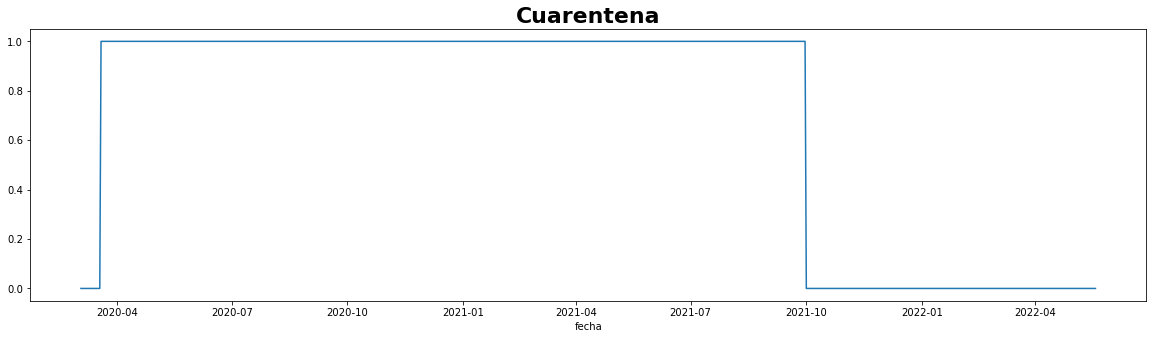

In [44]:
plt.figure(figsize=(20,5))
plt.plot(cuaren_arg.stay_home_requirements)
plt.title("Cuarentena", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

In [45]:
dt_arg = datos_paises[(datos_paises.location == "Argentina")]
dt_arg.drop(columns="location", inplace=True)
dt_arg.dropna(inplace=True)
dt_arg.set_index("date", inplace=True)
dt_arg["y_cuarentena"] = cuaren_arg.stay_home_requirements

In [46]:
dt_arg

,new_cases_smoothed,reproduction_rate,stringency_index,y_cuarentena
date,,,,
2020-03-21,17.714,2.38,88.89,1
2020-03-22,31.571,2.39,88.89,1
2020-03-23,35.000,2.25,100.00,1
2020-03-24,45.571,2.12,100.00,1
2020-03-25,44.000,2.02,100.00,1
...,...,...,...,...
2022-05-15,4855.571,-0.04,39.81,0
2022-05-16,4855.571,-0.04,39.81,0
2022-05-17,4855.571,-0.04,39.81,0


In [47]:
dt_arg.isna().sum()

new_cases_smoothed    0
reproduction_rate     0
stringency_index      0
y_cuarentena          0
dtype: int64

### Modelo

In [48]:
X = dt_arg.drop(columns=["y_cuarentena"])
y = dt_arg.y_cuarentena

##### 4. **Escalado de los datos**

In [49]:
col = X.columns

In [50]:
# X = pd.DataFrame(X)
# X.columns = col

In [51]:
col

Index(['new_cases_smoothed', 'reproduction_rate', 'stringency_index'], dtype='object')

In [52]:
X

,new_cases_smoothed,reproduction_rate,stringency_index
date,,,
2020-03-21,17.714,2.38,88.89
2020-03-22,31.571,2.39,88.89
2020-03-23,35.000,2.25,100.00
2020-03-24,45.571,2.12,100.00
2020-03-25,44.000,2.02,100.00
...,...,...,...
2022-05-15,4855.571,-0.04,39.81
2022-05-16,4855.571,-0.04,39.81
2022-05-17,4855.571,-0.04,39.81


In [53]:
escalador = StandardScaler()

In [54]:

X_escalado = escalador.fit_transform(X)
# X_escalado = X
X_escalado
type(X_escalado)

X_escalado = pd.DataFrame(X_escalado)
X_escalado.columns = col

In [55]:
X_escalado

,new_cases_smoothed,reproduction_rate,stringency_index
0,-0.637201,3.817818,0.934869
1,-0.636436,3.845706,0.934869
2,-0.636246,3.455279,1.533430
3,-0.635662,3.092739,1.533430
4,-0.635749,2.813863,1.533430
...,...,...,...
785,-0.369922,-2.930991,-1.709360
786,-0.369922,-2.930991,-1.709360
787,-0.369922,-2.930991,-1.709360
788,-0.369922,-2.958879,-1.709360


In [56]:
X_escalado = pd.DataFrame(X_escalado)
X_escalado.columns = col

In [57]:
X_escalado.columns

Index(['new_cases_smoothed', 'reproduction_rate', 'stringency_index'], dtype='object')

In [58]:
X_escalado

,new_cases_smoothed,reproduction_rate,stringency_index
0,-0.637201,3.817818,0.934869
1,-0.636436,3.845706,0.934869
2,-0.636246,3.455279,1.533430
3,-0.635662,3.092739,1.533430
4,-0.635749,2.813863,1.533430
...,...,...,...
785,-0.369922,-2.930991,-1.709360
786,-0.369922,-2.930991,-1.709360
787,-0.369922,-2.930991,-1.709360
788,-0.369922,-2.958879,-1.709360


In [59]:
logreg = LogisticRegression()

In [60]:
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X_escalado,y, test_size=0.3, random_state=1)

In [61]:
#  penalty — Specify the norm of the penalty.
#  C — Inverse of regularization strength; smaller values specify stronger regularization.
#  solver — Algorithm to use in the optimization problem.
#  max_iter — Maximum number of iterations taken for the solvers to converge.

# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [62]:
model = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10,                     # number of folds
                   n_jobs= 8)                     

In [63]:
model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=8,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [64]:
print("Tuned Hyperparameters :", model.best_params_)
print("Accuracy :",model.best_score_)

Tuned Hyperparameters : {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy : 1.0


In [65]:
logreg = LogisticRegression(**model.best_params_)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.01, solver='liblinear')

In [66]:
y_test_pred = logreg.predict(X_test)
y_train_pred = logreg.predict(X_train)

Train
AC SCORE: 1.0
F1 SCORE:  1.0


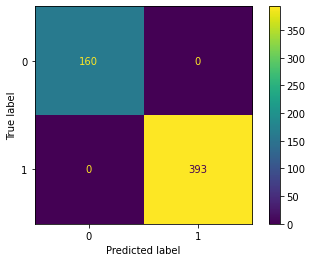

In [67]:
print("Train")
puntajes(X_train, y_train, y_train_pred, logreg,)

Test
AC SCORE: 1.0
F1 SCORE:  1.0


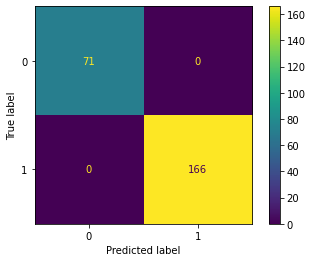

In [68]:
print("Test")
puntajes(X_test, y_test, y_test_pred, logreg)

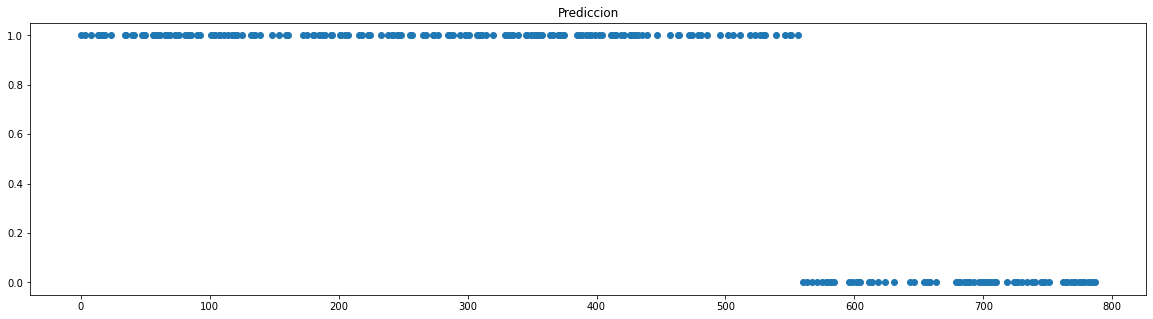

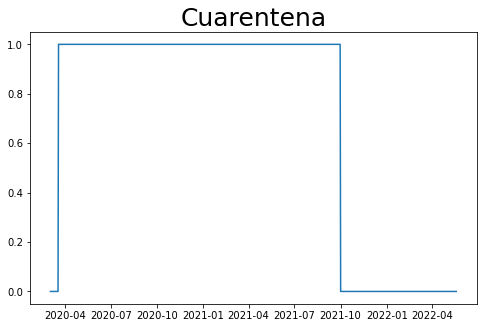

In [69]:
plt.figure(figsize=(20,5))
plt.scatter(X_test.index, y_test_pred)
plt.title("Prediccion")

plt.figure(figsize=(8,5))
plt.title("Cuarentena", fontsize=25)
plt.plot(cuaren_arg.stay_home_requirements)

In [70]:
score_arg = logreg.score(X_test, y_test)
w0 = logreg.intercept_[0]
w = w1, w2, w3 = logreg.coef_[0]
 
equation = "y = %f + (%f * x1) + (%f * x2) + (%f * x3)" % (w0, w1, w2, w3)
print(equation)

model_arg_ec = pd.DataFrame({"Pais":"Argentina","w0":[w0], "w1":[w1], "w2":[w2], "w3":[w3], "Score":[score_arg]})
model_arg_ec

y = 0.541546 + (-0.135410 * x1) + (0.042174 * x2) + (1.051855 * x3)


,Pais,w0,w1,w2,w3,Score
0,Argentina,0.541546,-0.13541,0.042174,1.051855,1.0


              feature  importance
2    stringency_index    2.862958
1   reproduction_rate    1.043076
0  new_cases_smoothed    0.873358


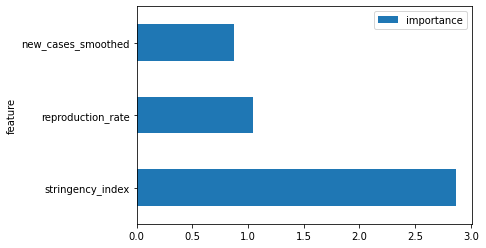

In [71]:
import math
# feature_names = X_escalado.columns
# feature_names = ["total_cases_per_million","new_cases_smoothed_per_million","reproduction_rate","stringency_index"]

feature_names = ["new_cases_smoothed","reproduction_rate","stringency_index"]


feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
print(feature_importance)
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

## 10 PAISES

### Preprocesamiento

In [72]:
cuaren_paises = data_cuarentena[data_cuarentena.Entity.isin(sel2_paises)]
cuaren_paises.set_index("Day", inplace=True)

In [73]:
list = []

for i in sel2_paises:

    dt = datos_paises[(datos_paises.location == i)]
    dt.drop(columns="location", inplace=True)
    dt.fillna(0,inplace=True)
    dt.set_index("date", inplace=True)
    dt["y_cuarentena"] = cuaren_paises[cuaren_paises.Entity == i].stay_home_requirements
    list.append(dt)

dt_modelo = pd.concat(list)

In [74]:
list

[            new_cases_smoothed  reproduction_rate  stringency_index  \
 date                                                                  
 2020-01-01               0.000                0.0               0.0   
 2020-01-02               0.000                0.0               0.0   
 2020-01-03               0.000                0.0               0.0   
 2020-01-04               0.000                0.0               0.0   
 2020-01-05               0.000                0.0               0.0   
 ...                        ...                ...               ...   
 2022-05-25            6212.429                0.0               0.0   
 2022-05-26            6212.429                0.0               0.0   
 2022-05-27            6212.429                0.0               0.0   
 2022-05-28            6212.429                0.0               0.0   
 2022-05-29            7396.857                0.0               0.0   
 
             y_cuarentena  
 date                      
 2020-

In [75]:
dt_modelo

,new_cases_smoothed,reproduction_rate,stringency_index,y_cuarentena
date,,,,
2020-01-01,0.000,0.0,0.00,0.0
2020-01-02,0.000,0.0,0.00,0.0
2020-01-03,0.000,0.0,0.00,0.0
2020-01-04,0.000,0.0,0.00,0.0
2020-01-05,0.000,0.0,0.00,0.0
...,...,...,...,...
2022-05-25,1640.714,0.0,26.85,0.0
2022-05-26,1566.857,0.0,26.85,0.0
2022-05-27,0.000,0.0,26.85,0.0


In [76]:
dt_modelo.reset_index(drop=True)

,new_cases_smoothed,reproduction_rate,stringency_index,y_cuarentena
0,0.000,0.0,0.00,0.0
1,0.000,0.0,0.00,0.0
2,0.000,0.0,0.00,0.0
3,0.000,0.0,0.00,0.0
4,0.000,0.0,0.00,0.0
...,...,...,...,...
8416,1640.714,0.0,26.85,0.0
8417,1566.857,0.0,26.85,0.0
8418,0.000,0.0,26.85,0.0
8419,0.000,0.0,26.85,0.0


In [77]:
dt_modelo.isna().sum()

new_cases_smoothed      0
reproduction_rate       0
stringency_index        0
y_cuarentena          907
dtype: int64

In [78]:
dt_modelo.dropna(inplace=True)

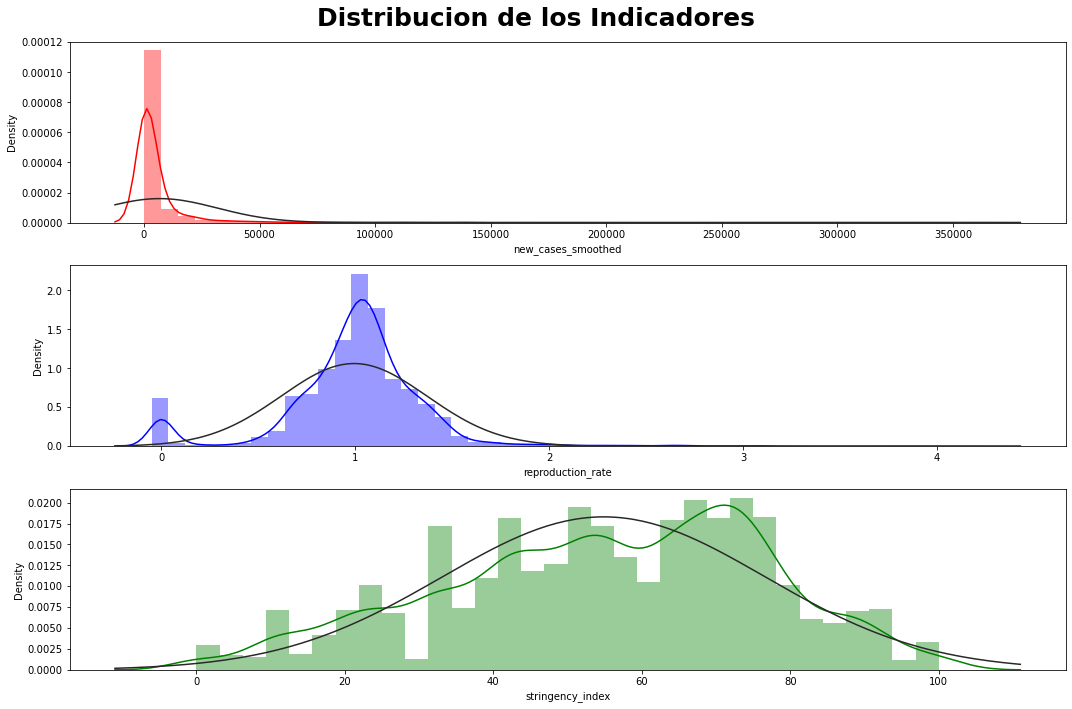

In [79]:
from scipy.stats import norm
#distribuciones
fig, axes = plt.subplots(3, figsize=(15,10))

fig.suptitle('Distribucion de los Indicadores', fontsize="25", fontweight="bold")

# ["new_cases_smoothed_per_million","reproduction_rate","stringency_index"]

sns.distplot(ax=axes[0], a=dt_modelo.new_cases_smoothed,fit=norm, kde=True,color= "r")
# sns.distplot(ax=axes[1], a=dt_modelo["%vaccinated"],fit=norm, kde=True,color= "r")
sns.distplot(ax=axes[1], a=dt_modelo.reproduction_rate,fit=norm, kde=True, color= "b")
sns.distplot(ax=axes[2], a=dt_modelo.stringency_index,fit=norm, kde=True,  color= "g")

plt.tight_layout()


In [80]:
X = dt_modelo.drop(columns=["y_cuarentena"])
y = dt_modelo.y_cuarentena

In [81]:
X_escalado = escalador.fit_transform(X)
# X_escalado = X
X_escalado
type(X_escalado)

X_escalado = pd.DataFrame(X_escalado)
X_escalado.columns = col

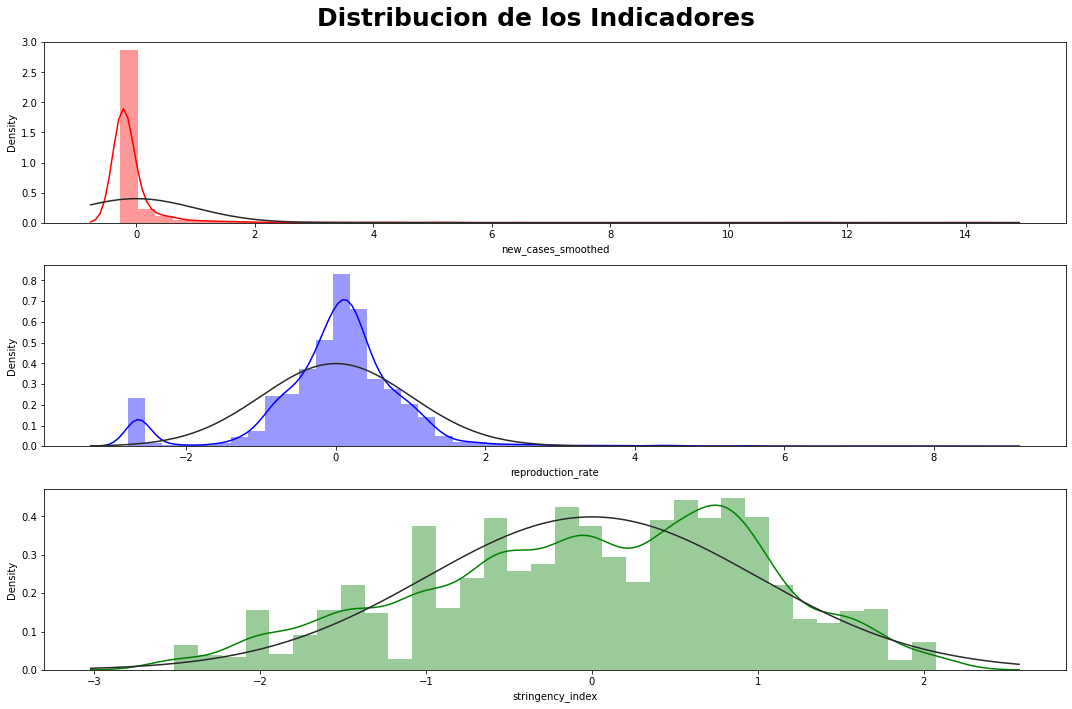

In [82]:
from scipy.stats import norm
#distribuciones
fig, axes = plt.subplots(3, figsize=(15,10))

fig.suptitle('Distribucion de los Indicadores', fontsize="25", fontweight="bold")



sns.distplot(ax=axes[0], a=X_escalado.new_cases_smoothed,fit=norm, kde=True,color= "r")
# sns.distplot(ax=axes[1], a=dt_modelo["%vaccinated"],fit=norm, kde=True,color= "r")
sns.distplot(ax=axes[1], a=X_escalado.reproduction_rate,fit=norm, kde=True, color= "b")
sns.distplot(ax=axes[2], a=X_escalado.stringency_index,fit=norm, kde=True,  color= "g")


plt.tight_layout()

### Modelos

#### Regresion Logistica

In [85]:
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X_escalado,y, test_size=0.3, random_state=1)


In [86]:
logreg = LogisticRegression()
# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [87]:
model = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10,
                   n_jobs=-1)                     # number of folds

In [88]:
model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [89]:
print("Tuned Hyperparameters :", model.best_params_)
print("Accuracy :",model.best_score_)

Tuned Hyperparameters : {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.845602752127467


In [90]:
logreg = LogisticRegression(**model.best_params_)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.01, solver='newton-cg')

In [91]:
y_test_pred = logreg.predict(X_test)
y_train_pred = logreg.predict(X_train)

In [92]:
print("Train")
puntajes(X_train,y_train, y_train_pred, logreg,False)

Train
AC SCORE: 0.8463586233124168
F1 SCORE:  0.8438255446384907


Test
AC SCORE: 0.844789356984479
F1 SCORE:  0.8432848223426734


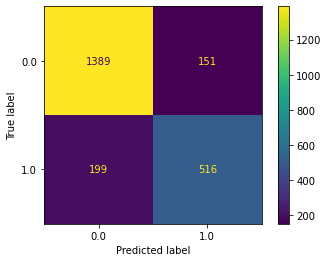

In [93]:
print("Test")
puntajes(X_test,y_test, y_test_pred, logreg)

In [94]:
score_paises = logreg.score(X_test, y_test)
w0 = logreg.intercept_[0]
w = w1, w2, w3 = logreg.coef_[0]
 
equation = "y = %f + (%f * x1) + (%f * x2) + (%f * x3) " % (w0, w1, w2, w3)
print(equation)

model_paises_ec = pd.DataFrame({"Seleccion":"Paises","w0":[w0], "w1":[w1], "w2":[w2], "w3":[w3], "Score":[score_paises]})
model_paises_ec

y = -1.410296 + (-0.085330 * x1) + (-0.158530 * x2) + (2.049955 * x3) 


,Seleccion,w0,w1,w2,w3,Score
0,Paises,-1.410296,-0.08533,-0.15853,2.049955,0.844789


##### Importancias de los indicadores

              feature  importance
2    stringency_index    7.767549
0  new_cases_smoothed    0.918209
1   reproduction_rate    0.853397


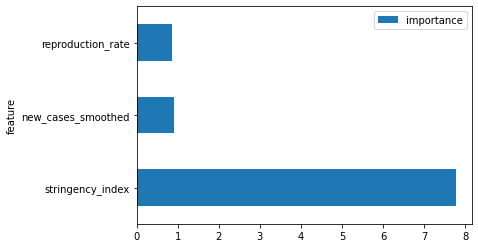

In [95]:
# feature_names = ["total_cases_per_million","new_cases_smoothed_per_million","reproduction_rate","stringency_index"]

feature_names = ["new_cases_smoothed","reproduction_rate","stringency_index"]


feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
print(feature_importance)
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

#### Naive Bayes

In [96]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [97]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
model = GridSearchCV(gnb,                    # model
                   param_grid = params_NB,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10,
                   n_jobs=-1)                     # number of folds
model.fit(X_train,y_train)
print(model.best_params_)
print(model.best_score_)

{'var_smoothing': 1.0}
0.836285352163679


In [98]:
gnb = GaussianNB(**model.best_params_)
gnb.fit(X_train, y_train)
y_test_pred = gnb.predict(X_test)
y_train_pred = gnb.predict(X_train)


In [99]:
print("Train")
puntajes(X_train,y_train, y_train_pred, gnb,False)

Train
AC SCORE: 0.8368511123787792
F1 SCORE:  0.8353713740825206


Test
AC SCORE: 0.8425720620842572
F1 SCORE:  0.8421191277338029


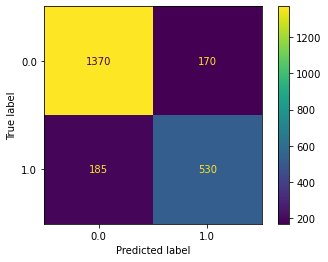

In [100]:
print("Test")
puntajes(X_test,y_test, y_test_pred, gnb)

## Prueba en paises nuevos

## Preprocesamiento

In [101]:
sel3paises = ["India","Chile","Germany","Sweden","Mexico","Italy"
        "Russia","Thailand","Kazakhstan","Australia","Ukraine"]

In [102]:
cuaren_paises = data_cuarentena[data_cuarentena.Entity.isin(sel3paises)]
cuaren_paises.set_index("Day", inplace=True)

In [103]:
datos_paises = datos[(datos.location.isin(sel3paises)) & (datos.date < "2022-05-01")]
datos_paises = datos[datos.location.isin(sel3paises)]


# datos_paises = datos_paises[["location","date","total_cases_per_million","new_cases_smoothed_per_million","reproduction_rate","stringency_index"]]

# datos_paises = datos_paises[["location","date","new_cases_smoothed_per_million","reproduction_rate","stringency_index"]]

datos_paises = datos_paises[["location","date","total_cases","new_cases_smoothed","people_fully_vaccinated","population" ,"reproduction_rate","stringency_index"]]
datos_paises.date = pd.to_datetime(datos_paises.date)
datos_paises

,location,date,total_cases,new_cases_smoothed,people_fully_vaccinated,population,reproduction_rate,stringency_index
9928,Australia,2020-01-26,4.0,NaN,NaN,25788217.0,NaN,5.56
9929,Australia,2020-01-27,5.0,NaN,NaN,25788217.0,NaN,5.56
9930,Australia,2020-01-28,5.0,NaN,NaN,25788217.0,NaN,5.56
9931,Australia,2020-01-29,6.0,NaN,NaN,25788217.0,NaN,5.56
9932,Australia,2020-01-30,9.0,NaN,NaN,25788217.0,NaN,5.56
...,...,...,...,...,...,...,...,...
177486,Ukraine,2022-05-25,5040518.0,0.0,NaN,43466822.0,NaN,NaN
177487,Ukraine,2022-05-26,5040518.0,0.0,NaN,43466822.0,NaN,NaN
177488,Ukraine,2022-05-27,5040518.0,0.0,NaN,43466822.0,NaN,NaN
177489,Ukraine,2022-05-28,5040518.0,0.0,NaN,43466822.0,NaN,NaN


In [104]:
# datos_paises = datos_paises[["location","date","total_cases","new_cases_smoothed","people_fully_vaccinated","population" ,"reproduction_rate","stringency_index"]]


# datos_paises["%new case"] = datos_paises["new_cases_smoothed"] /datos_paises["total_cases"]

# datos_paises["%vaccinated"] = datos_paises["people_fully_vaccinated"] /datos_paises["population"]

datos_paises

datos_paises.drop(columns=["total_cases","people_fully_vaccinated","population"], inplace=True)

In [105]:
list = []

for i in sel3paises:

    dt = datos_paises[(datos_paises.location == i)]
    dt.drop(columns="location", inplace=True)
    dt.fillna(0,inplace=True)
    dt.set_index("date", inplace=True)
    dt["y_cuarentena"] = cuaren_paises[cuaren_paises.Entity == i].stay_home_requirements
    list.append(dt)

dt_modelo_2 = pd.concat(list)

In [106]:
dt_modelo_2.isna().sum()

new_cases_smoothed     0
reproduction_rate      0
stringency_index       0
y_cuarentena          85
dtype: int64

In [107]:
dt_modelo_2.dropna(inplace=True)

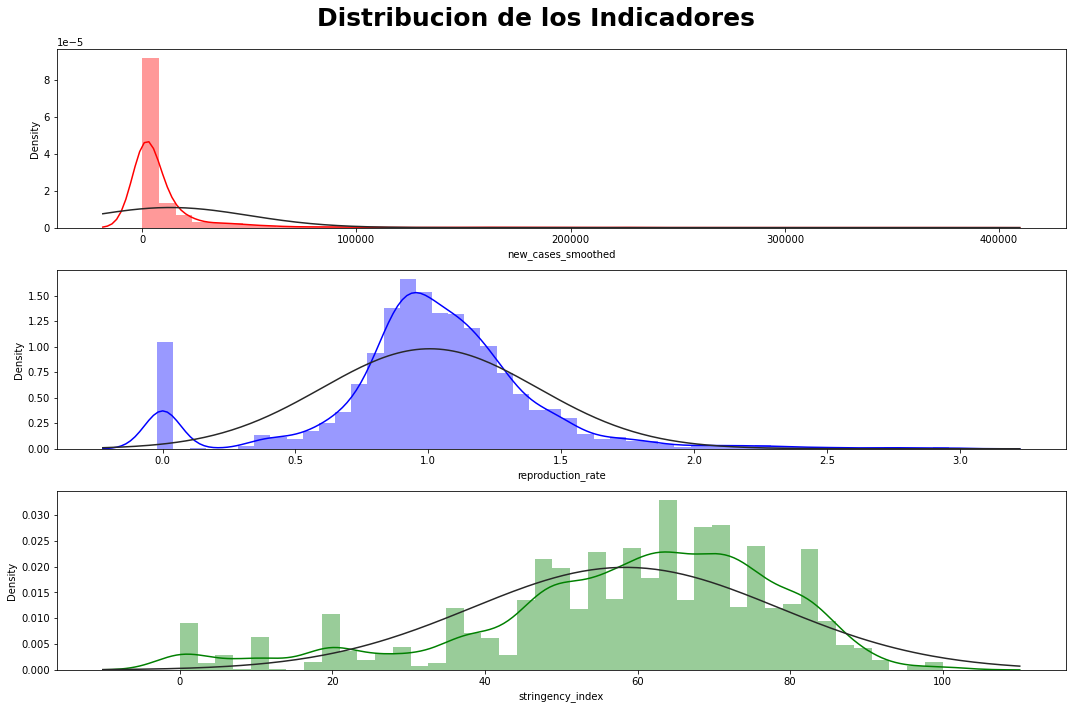

In [108]:
from scipy.stats import norm
#distribuciones
fig, axes = plt.subplots(3, figsize=(15,10))

fig.suptitle('Distribucion de los Indicadores', fontsize="25", fontweight="bold")

sns.distplot(ax=axes[0], a=dt_modelo_2.new_cases_smoothed,fit=norm, kde=True,color= "r")
# sns.distplot(ax=axes[1], a=dt_modelo_2["%vaccinated"],fit=norm, kde=True,color= "r")
sns.distplot(ax=axes[1], a=dt_modelo_2.reproduction_rate,fit=norm, kde=True, color= "b")
sns.distplot(ax=axes[2], a=dt_modelo_2.stringency_index,fit=norm, kde=True,  color= "g")

plt.tight_layout()


## Modelos

In [109]:
X_final = dt_modelo_2.drop(columns="y_cuarentena")
y_final = dt_modelo_2.y_cuarentena

In [110]:
X_final_escalado = escalador.transform(X_final)
# X_escalado = X
X_final_escalado

X_final_escalado = pd.DataFrame(X_final_escalado)
X_final_escalado.columns = col

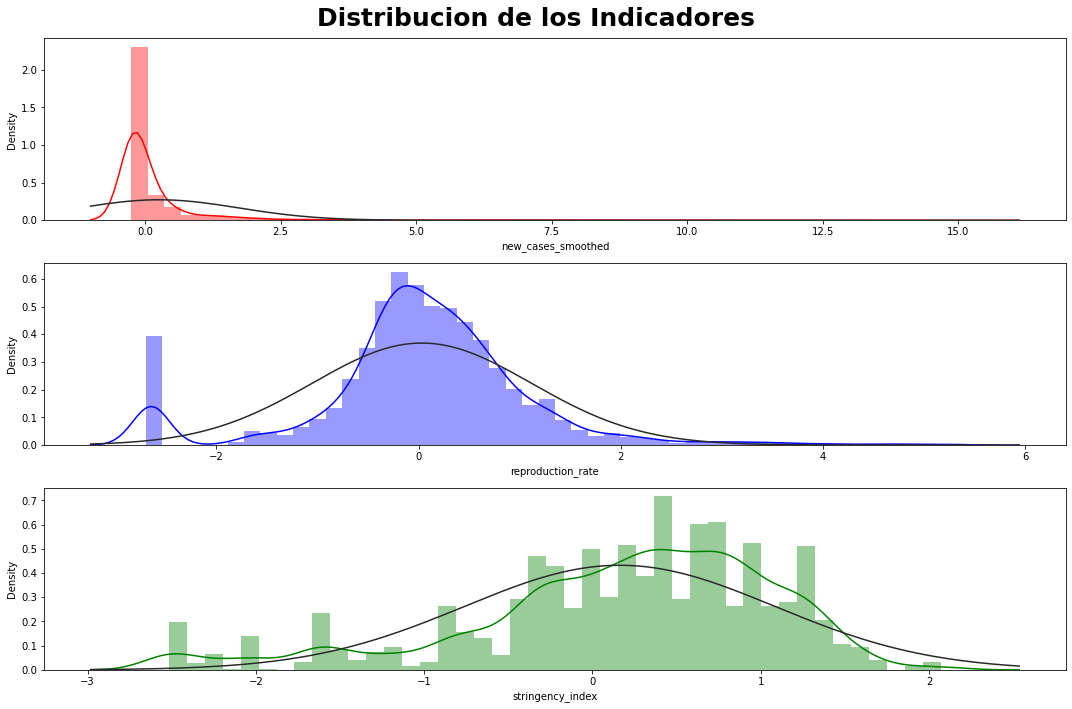

In [111]:
from scipy.stats import norm
#distribuciones
fig, axes = plt.subplots(3, figsize=(15,10))

fig.suptitle('Distribucion de los Indicadores', fontsize="25", fontweight="bold")

sns.distplot(ax=axes[0], a=X_final_escalado.new_cases_smoothed,fit=norm, kde=True,color= "r")
# sns.distplot(ax=axes[1], a=X_final_escalado["%vaccinated"],fit=norm, kde=True,color= "r")
sns.distplot(ax=axes[1], a=X_final_escalado.reproduction_rate,fit=norm, kde=True, color= "b")
sns.distplot(ax=axes[2], a=X_final_escalado.stringency_index,fit=norm, kde=True,  color= "g")

plt.tight_layout()

In [112]:
X_final

,new_cases_smoothed,reproduction_rate,stringency_index
date,,,
2020-01-30,0.0,0.0,10.19
2020-01-31,0.0,0.0,10.19
2020-02-01,0.0,0.0,10.19
2020-02-02,0.0,0.0,10.19
2020-02-03,0.0,0.0,10.19
...,...,...,...
2022-05-20,0.0,0.0,75.00
2022-05-21,0.0,0.0,75.00
2022-05-22,0.0,0.0,75.00


In [113]:
X_final_escalado


,new_cases_smoothed,reproduction_rate,stringency_index
0,-0.268742,-2.644636,-2.049837
1,-0.268742,-2.644636,-2.049837
2,-0.268742,-2.644636,-2.049837
3,-0.268742,-2.644636,-2.049837
4,-0.268742,-2.644636,-2.049837
...,...,...,...
7529,-0.268742,-2.644636,0.923690
7530,-0.268742,-2.644636,0.923690
7531,-0.268742,-2.644636,0.923690
7532,-0.268742,-2.644636,0.923690


### Regresion Logistica

In [114]:
# y_final_predict = logreg.predict(X_final)

y_final_predict = logreg.predict(X_final_escalado)


In [115]:
len(y_final_predict)

7534

In [116]:
from sklearn.metrics import accuracy_score
accuracy_score(y_final, y_final_predict)
# accuracy_score(y_final, y_final_predict)
# y_final_predict

0.8144411998938147

AC SCORE: 0.8144411998938147
F1 SCORE:  0.8091219281753922


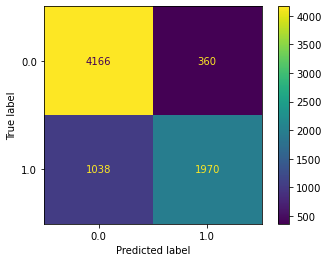

In [117]:
puntajes(X_final_escalado,y_final, y_final_predict, logreg)
# puntajes(X_final,y_final, y_final_predict, logreg)
# y_final_predict

### Naive Bayes

In [118]:
y_final_predict = gnb.predict(X_final_escalado)
from sklearn.metrics import accuracy_score
accuracy_score(y_final, y_final_predict)

0.7851075126095036

AC SCORE: 0.7851075126095036
F1 SCORE:  0.7792300290586776


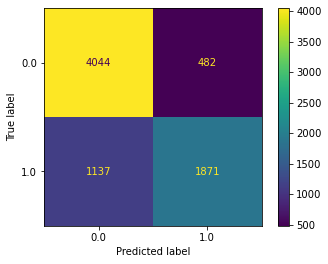

In [119]:
puntajes(X_final_escalado,y_final, y_final_predict, gnb)

## Conclusión

Podemos observar que el modelo de regresión logística que hemos entrenado dio una precisión aceptable con un ~80% a asertividad.

Hay que tener en cuenta que la variable "stringency_index", es obtenida tomando en cuenta si el país tiene cuarentena o no. por lo que el modelo no sería del todo funcional. pero de tener ese valor se podría determinar si el país realizo cuarentena o no. 


# Tercera parte: Elaboración de Informe Final

## Investigacion

### ¿Como funciona el modelo si lo probamos con todos los paises del dataset?

Preprocesamiento

In [120]:
cuaren_todo = data_cuarentena.copy()
cuaren_todo.set_index("Day", inplace=True)

In [121]:
# todo_dt = datos[["location","date","total_cases_per_million","new_cases_smoothed_per_million","reproduction_rate","stringency_index"]]

todo_dt = datos[["location","date","total_cases","new_cases_smoothed","people_fully_vaccinated","population" ,"reproduction_rate","stringency_index"]]
todo_dt.date = pd.to_datetime(todo_dt.date)
todo_dt

,location,date,total_cases,new_cases_smoothed,people_fully_vaccinated,population,reproduction_rate,stringency_index
0,Afghanistan,2020-02-24,5.0,NaN,NaN,39835428.0,NaN,8.33
1,Afghanistan,2020-02-25,5.0,NaN,NaN,39835428.0,NaN,8.33
2,Afghanistan,2020-02-26,5.0,NaN,NaN,39835428.0,NaN,8.33
3,Afghanistan,2020-02-27,5.0,NaN,NaN,39835428.0,NaN,8.33
4,Afghanistan,2020-02-28,5.0,NaN,NaN,39835428.0,NaN,8.33
...,...,...,...,...,...,...,...,...
190192,Zimbabwe,2022-05-25,251228.0,174.429,4487255.0,15092171.0,NaN,NaN
190193,Zimbabwe,2022-05-26,251646.0,205.714,4493290.0,15092171.0,NaN,NaN
190194,Zimbabwe,2022-05-27,251959.0,212.857,NaN,15092171.0,NaN,NaN
190195,Zimbabwe,2022-05-28,251959.0,212.857,NaN,15092171.0,NaN,NaN


In [122]:
# todo_dt = todo_dt[["location","date","total_cases","new_cases_smoothed","people_fully_vaccinated","population" ,"reproduction_rate","stringency_index"]]

# todo_dt["%new case"] = todo_dt["new_cases_smoothed"] /todo_dt["total_cases"]

# todo_dt["%vaccinated"] = todo_dt["people_fully_vaccinated"] /todo_dt["population"]

todo_dt.drop(columns=["total_cases","people_fully_vaccinated","population"], inplace=True)

In [123]:
sel4paises = todo_dt.location.unique().tolist()

In [124]:
list = []

for i in sel4paises:

    dt = todo_dt[(todo_dt.location == i)]
    dt.drop(columns="location", inplace=True)
    dt.fillna(0,inplace=True)
    dt.set_index("date", inplace=True)
    dt["y_cuarentena"] = cuaren_todo[cuaren_todo.Entity == i].stay_home_requirements
    list.append(dt)

dt_modelo_3 = pd.concat(list)

In [125]:
dt_modelo_3

,new_cases_smoothed,reproduction_rate,stringency_index,y_cuarentena
date,,,,
2020-02-24,0.000,0.0,8.33,0.0
2020-02-25,0.000,0.0,8.33,0.0
2020-02-26,0.000,0.0,8.33,0.0
2020-02-27,0.000,0.0,8.33,0.0
2020-02-28,0.000,0.0,8.33,0.0
...,...,...,...,...
2022-05-25,174.429,0.0,0.00,NaN
2022-05-26,205.714,0.0,0.00,NaN
2022-05-27,212.857,0.0,0.00,NaN


In [126]:
dt_modelo_3.dropna(inplace=True)

In [127]:
X = dt_modelo_3.drop(columns=["y_cuarentena"])
y = dt_modelo_3.y_cuarentena

In [128]:
X_escalado = escalador.transform(X)
# X_escalado = X
X_escalado
type(X_escalado)

X_escalado = pd.DataFrame(X_escalado)
X_escalado.columns = col

 Regresion Logistica

In [129]:
y_final_predict = logreg.predict(X_escalado)

In [130]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_final_predict)
# accuracy_score(y_final, y_final_predict)
# y_final_predict

0.7870316731108626

AC SCORE: 0.7870316731108626
F1 SCORE:  0.7755228287182073


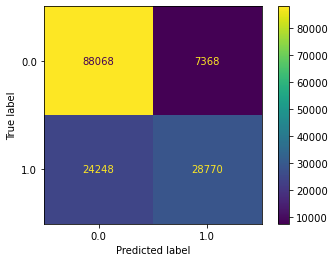

In [131]:
puntajes(X_escalado,y, y_final_predict, logreg)
# puntajes(X_final,y_final, y_final_predict, logreg)
# y_final_predict

Conclusión

Podemos corroborar los concluido anteriormente probando el modelo con todos los países.
Al evaluar los valores predichos se tiene una asertividad de ~80%. siendo este un valor bastante bueno.

### ¿Existe una relacion entre el promedio de dias que se hizo y no se hizo cuarentena, y el porcentaje de la poblacion contagiada acumulada?

Agregar, el filtro de primer caso, y trabajar la data desde la tabla madre.

In [132]:
excepciones = ["Africa","Asia","Europe","European Union","High income","Lower middle income","South America","Upper middle income","World"]

In [133]:
prom = data_cuarentena.groupby("Entity").mean().sort_values(by=["stay_home_requirements"])
prom

,stay_home_requirements
Entity,
Iceland,0.000000
Cote d'Ivoire,0.000000
Norway,0.000000
Denmark,0.000000
Cameroon,0.000000
...,...
Rwanda,0.830012
Jamaica,0.833910
Myanmar,0.880734


In [134]:
por_poblacion = datos[["location","total_cases","population","reproduction_rate"]].groupby("location").max()

In [135]:
por_poblacion[por_poblacion.total_cases > 10000000]

,total_cases,population,reproduction_rate
location,,,
Africa,11875952.0,1.373486e+09,NaN
Asia,153330857.0,4.678445e+09,NaN
Brazil,30953579.0,2.139934e+08,3.12
Europe,198228612.0,7.489630e+08,NaN
European Union,142363395.0,4.471899e+08,NaN
France,29533709.0,6.742200e+07,3.09
Germany,26244107.0,8.390047e+07,3.02
High income,306824217.0,1.214930e+09,NaN
India,43155749.0,1.393409e+09,2.77


In [136]:
por_poblacion.drop(labels=excepciones, inplace=True)

In [137]:
por_poblacion

,total_cases,population,reproduction_rate
location,,,
Afghanistan,180174.0,39835428.0,1.68
Albania,276101.0,2872934.0,2.01
Algeria,265873.0,44616626.0,2.09
Andorra,42894.0,77354.0,1.70
Angola,99527.0,33933611.0,3.05
...,...,...,...
Wallis and Futuna,454.0,11094.0,NaN
Western Sahara,NaN,611872.0,NaN
Yemen,11819.0,30490639.0,1.82


In [138]:
por_poblacion["prom_cuarentena"] = prom.stay_home_requirements
por_poblacion["por_pob_contagiada"] = (por_poblacion.total_cases / por_poblacion.population) * 100

In [139]:
por_poblacion.isna().sum()

total_cases           15
population             2
reproduction_rate     45
prom_cuarentena       49
por_pob_contagiada    16
dtype: int64

In [140]:
por_poblacion.dropna(inplace=True)
por_poblacion.isna().sum()

total_cases           0
population            0
reproduction_rate     0
prom_cuarentena       0
por_pob_contagiada    0
dtype: int64

In [141]:
por_poblacion

,total_cases,population,reproduction_rate,prom_cuarentena,por_pob_contagiada
location,,,,,
Afghanistan,180174.0,39835428.0,1.68,0.198167,0.452296
Albania,276101.0,2872934.0,2.01,0.580499,9.610419
Algeria,265873.0,44616626.0,2.09,0.665127,0.595906
Andorra,42894.0,77354.0,1.70,0.014874,55.451560
Angola,99527.0,33933611.0,3.05,0.264472,0.293299
...,...,...,...,...,...
Venezuela,523618.0,28704947.0,1.89,0.665143,1.824139
Vietnam,10717251.0,98168829.0,2.00,0.583716,10.917163
Yemen,11819.0,30490639.0,1.82,0.697809,0.038763


In [142]:
por_poblacion.describe()

,total_cases,population,reproduction_rate,prom_cuarentena,por_pob_contagiada
count,1.760000e+02,1.760000e+02,176.000000,176.000000,176.000000
mean,2.989414e+06,4.441710e+07,2.234943,0.340761,13.726341
std,8.497968e+06,1.558034e+08,0.780537,0.260074,15.259941
min,3.098000e+03,3.401000e+04,0.550000,0.000000,0.035936
25%,6.384550e+04,3.312826e+06,1.700000,0.107469,0.935545
50%,4.959750e+05,1.019563e+07,2.120000,0.301371,8.054176
75%,1.898648e+06,3.292200e+07,2.640000,0.560202,19.989481
max,8.398464e+07,1.444216e+09,5.910000,0.896074,55.451560


In [143]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()

In [144]:
por_pob_reg = por_poblacion.por_pob_contagiada.values.reshape(-1,1)
prom_cuare_reg = por_poblacion.prom_cuarentena.values.reshape(-1,1)

linear_reg.fit(prom_cuare_reg,por_pob_reg)
y_pred = linear_reg.predict(prom_cuare_reg)

In [145]:
m = linear_reg.coef_[0][0]
c = linear_reg.intercept_[0]
print(m)
print(c)

-14.40309412361198
18.63435596832524


Text(0.5, 1.0, 'Relacion entre % de contagiados y promedio de dias hechos cuarentena')

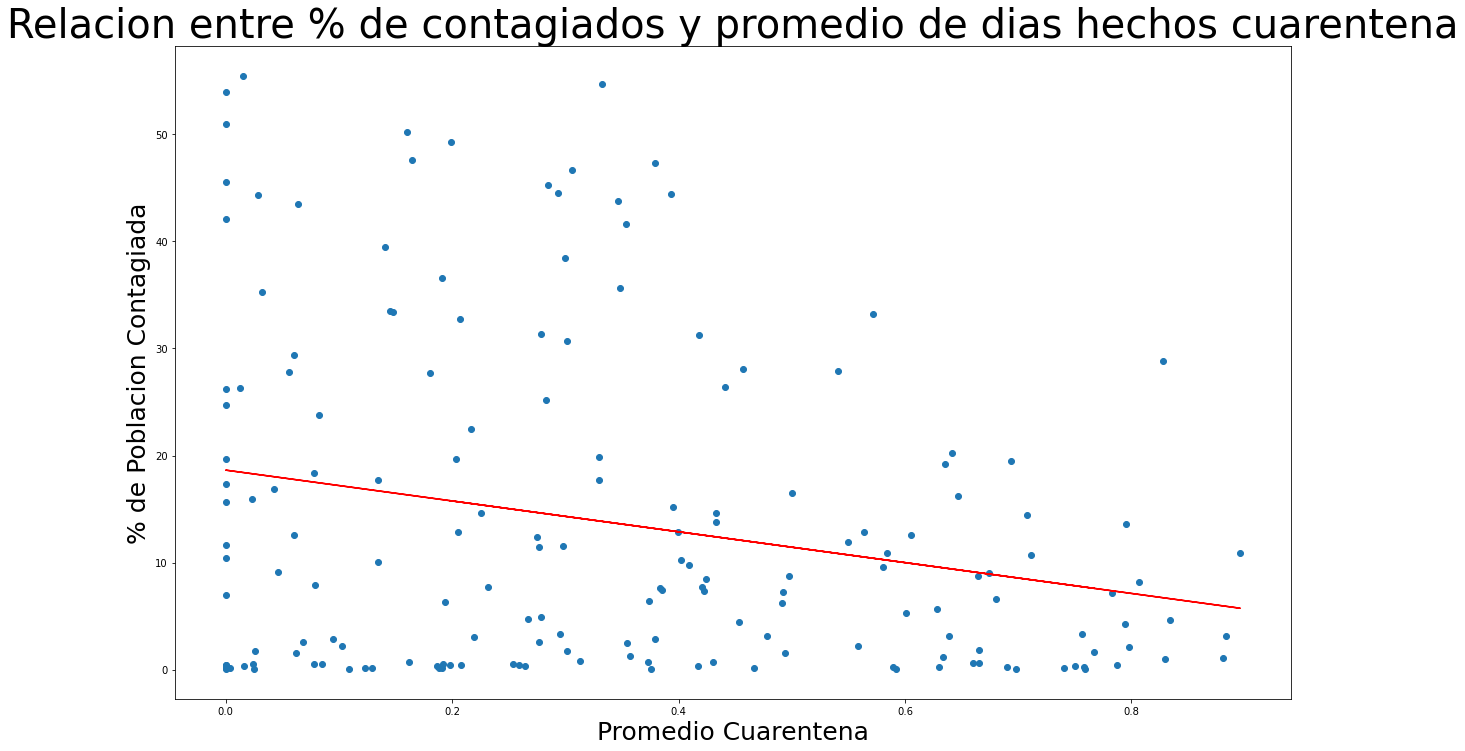

In [146]:
plt.figure(figsize=(20,12))
plt.scatter(por_poblacion.prom_cuarentena, por_poblacion.por_pob_contagiada)
plt.plot(prom_cuare_reg, y_pred, color="red")
plt.ylabel("% de Poblacion Contagiada", fontsize=25)
plt.xlabel("Promedio Cuarentena",fontsize=25)
plt.title("Relacion entre % de contagiados y promedio de dias hechos cuarentena", fontsize=40)

#### Conclusion

Podemos observar que los países que realizar una cuarentena más extensa tienden a tener un menor porcentaje de la población contagiada. 

### ¿Como se ve afectado el valor K al momento de imponer al momento de imponer la cuarentena?

Para encontrar la respuesta de esta pregunta se realizará un estudio del valor de k y despues de aplicar la pandemia, 

Para evaluar K inicial, se tomará una ventana desde el inicio de la cuarentena y de 4 a 9 dias antes.

Para el caso encontrar el k final, se desplazará la ventana 9 dias despues de aplicar la cuarentena, con el fin de dar tiempo a que las personas contagiadas antes de la cuarentena sean confirmadas positivas. 

Nota, se evaluará los países que hayan aplicado la cuarentena, 9 dias posteriores a haber confirmado el primer positivo, hasta los 59 dias del primer confirmado.


In [147]:
datos2 = datos[(datos["total_cases"] > 0)]
datos2.reset_index(inplace=True ,drop= "index")
paises=datos2['location'] #cargo el vector de paises
confirmados=datos2['total_cases'] #carga vector todos los casos confirmados
# paises_fecha =datos2["date"] #cargo el vector de paises
paises_fecha = pd.to_datetime(datos2.date)


In [148]:
# Encontramos el primer día donde haya habido cuarentena 
cuaren_arg2 = data_cuarentena[(data_cuarentena.stay_home_requirements == 1)]
gb = cuaren_arg2.groupby(["Entity"]).agg({'Day': [np.min]})
gb.reset_index( inplace= True)

In [149]:
def info_pais_quearentena (pais, date, ventana = 9,inicio_min= 9 , inicio_max = 45):


    ind=np.where(paises==pais)
    ind=ind[0]

    fechas = paises_fecha[ind]
    inicio_cuarentena = np.where(fechas==date)
    if len(inicio_cuarentena[0]) > 0 and inicio_cuarentena[0] > inicio_min  and inicio_cuarentena[0] < inicio_max:
        inicio_cuarentena = inicio_cuarentena[0][0]
    
        casos=confirmados[ind]
        dias=np.arange(0,len(casos))


        # K antes de cuarentena.
        casos_principio=casos[inicio_cuarentena-ventana:inicio_cuarentena]
        # print(casos_principio)
        casos_principio = casos_principio.dropna()
        if len(casos_principio) > 4:
            

            dias_principio=dias[inicio_cuarentena-len(casos_principio):inicio_cuarentena]
            # print(dias_principio)
            
            if casos_principio.std() > 0:
                popt, pcov = curve_fit(exponencial, dias_principio, casos_principio,maxfev=1000000)
                k=popt[0]
                t0_=popt[1]

            else:
                k=0
                t0_=0
            # casos_simu=exponencial(dias_principio,k,t0_)

            # K antes despues cuarentena.
            casos_final=casos[inicio_cuarentena+7:inicio_cuarentena+7+ventana]
            
            dias_final=dias[inicio_cuarentena+7:inicio_cuarentena+7+ventana]

            #ajustamos ---- scipy.optimize.curve_fit(f, xdata, ydata)
            if casos_final.std() > 0:
                popt, pcov = curve_fit(exponencial, dias_final, casos_final,maxfev=1000000)
                k1=popt[0]
                t0_1=popt[1]
            else:
                k1=0
                t0_1=0
            # casos_simu=exponencial(dias_principio,k,t0_)

            if k > 0:
                dic = {"Pais": pais , "t0":[inicio_cuarentena-ventana], "t":[inicio_cuarentena], "t1":[inicio_cuarentena+7+ventana] , "k": [k], "k1" : [k1], "%D" : [(k1-k)/k]}
                datos_pais = pd.DataFrame(data=dic)

                return datos_pais

In [150]:
list = []

for i in range(len(gb)):
    if i == 104:
        continue
    # print(i)
    df = info_pais_quearentena(gb["Entity"].iloc[i], gb["Day"]["amin"].iloc[i]
                                ,ventana = 9, inicio_min= 9, inicio_max = 60)
                               
    list.append(df)

df_f3 = pd.concat(list)
df_f3.shape

(97, 7)

In [151]:
df_f3.describe()

,t0,t,t1,k,k1,%D
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,16.773196,25.773196,41.773196,0.202549,0.087682,-0.301018
std,13.540453,13.540453,13.540453,0.158981,0.060123,1.236514
min,1.000000,10.000000,26.000000,0.011524,0.000000,-1.000000
25%,7.000000,16.000000,32.000000,0.108152,0.049486,-0.760990
50%,14.000000,23.000000,39.000000,0.184835,0.084508,-0.554900
75%,22.000000,31.000000,47.000000,0.236803,0.116865,-0.319029
max,50.000000,59.000000,75.000000,1.180525,0.460454,9.970275


In [152]:
df_f3[(df_f3.k1 == 0)]


,Pais,t0,t,t1,k,k1,%D
0,Seychelles,15,24,40,0.038174,0.0,-1.0
0,Suriname,5,14,30,0.137008,0.0,-1.0


In [153]:
df_f3[ (df_f3["%D"] > -0.09)]

,Pais,t0,t,t1,k,k1,%D
0,Afghanistan,21,30,46,0.076954,0.097778,0.270603
0,Cape Verde,3,12,28,0.089712,0.460454,4.132596
0,Central African Republic,45,54,70,0.074877,0.078434,0.047505
0,Congo,4,13,29,0.045945,0.077244,0.681224
0,Georgia,17,26,42,0.074800,0.082959,0.109073
0,India,43,52,68,0.184835,0.182592,-0.012139
0,Iraq,9,18,34,0.092241,0.122085,0.323534
0,Kuwait,18,27,43,0.080658,0.134006,0.661415
0,Palestine,8,17,33,0.049376,0.118596,1.401908
0,Papua New Guinea,9,18,34,0.070231,0.094741,0.348999


<AxesSubplot:xlabel='k'>

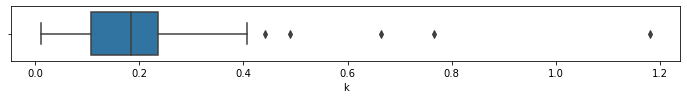

In [154]:
plt.figure(figsize = (12,1))
sns.boxplot(df_f3.k)

<AxesSubplot:xlabel='k1'>

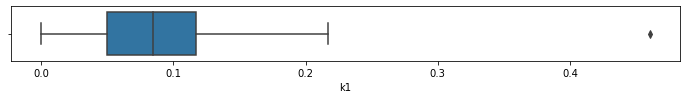

In [155]:
plt.figure(figsize = (12,1))
sns.boxplot(df_f3.k1)

<AxesSubplot:xlabel='%D'>

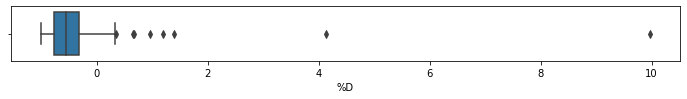

In [156]:
plt.figure(figsize = (12,1))
sns.boxplot(df_f3["%D"])

In [157]:
df_f3 = df_f3[(df_f3.k1 != 0) &(df_f3.k1 <0.3)  & (df_f3.k < 0.5) & (df_f3["%D"] < -0.02)]
df_f3.describe()

,t0,t,t1,k,k1,%D
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,16.858974,25.858974,41.858974,0.202481,0.078384,-0.575895
std,13.475061,13.475061,13.475061,0.092676,0.041212,0.214348
min,1.000000,10.000000,26.000000,0.011524,0.005441,-0.972155
25%,7.000000,16.000000,32.000000,0.141116,0.046657,-0.755658
50%,13.500000,22.500000,38.500000,0.204688,0.081112,-0.587647
75%,22.000000,31.000000,47.000000,0.260499,0.107986,-0.439921
max,50.000000,59.000000,75.000000,0.489535,0.185232,-0.123209


In [158]:
df_f3[(df_f3["Pais"] == "Argentina")]

,Pais,t0,t,t1,k,k1,%D
0,Argentina,7,16,32,0.205607,0.107993,-0.47476


In [159]:
val_k = df_f3.k
val_k1 = df_f3.k1
val_porc = df_f3["%D"]

Media de k_inicial/k_final:  0.2025 / 0.0784
Mediana de k_inicial/k_final:  0.2047 / 0.0811
Desvio estandar de k_inicial/k_final:  0.0927 / 0.0412
Proc_reduccion= -57.590 %


Text(0, 0.5, 'densidad')

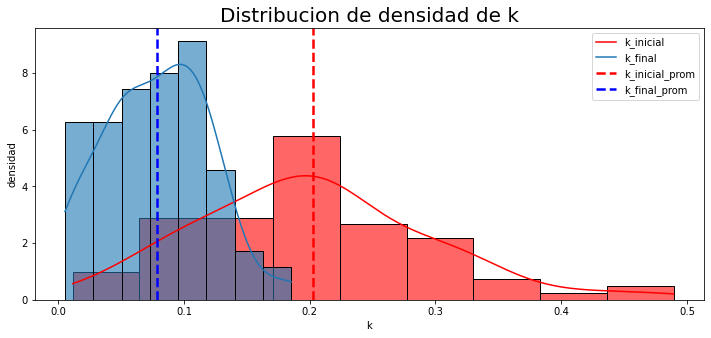

In [160]:
# Obtenemos valores estadisticos
proc_reduccion = (val_k1.mean()-val_k.mean())/val_k.mean()

print(f"Media de k_inicial/k_final:  %.4f / %.4f" % (val_k.mean(),val_k1.mean()))
print(f"Mediana de k_inicial/k_final:  %.4f / %.4f" % (val_k.median(),val_k1.median())) ##{ val_k.median() }")
print(f"Desvio estandar de k_inicial/k_final:  %.4f / %.4f" % (val_k.std(),val_k1.std())) ##{ val_k.std() }")
print(f"Proc_reduccion= %.3f" %(val_porc.mean()*100),"%")
# print(f"Proc_reduccion={proc_reduccion}")

plt.figure(figsize = (12,5))
sns.histplot(val_k,color="red", stat = 'density', kde=True, alpha=0.6, legend = "k_inicial")
sns.histplot(val_k1, stat = 'density', kde=True, alpha=0.6,legend = "k_final")
plt.axvline(x=val_k.mean(),
            color='red',
            ls='--',  
            lw=2.5)  
plt.axvline(x=val_k1.mean(),
            color='blue',
            ls='--',  
            lw=2.5)        
plt.title("Distribucion de densidad de k", fontsize=20)
labels= ["k_inicial","k_final","k_inicial_prom","k_final_prom" ]
plt.legend(labels,loc=0)
plt.xlabel("k")
plt.ylabel("densidad")

k_final=0.20272530775554365
k1_final=0.07821049745630859
Proc_reduccion=-0.614204569117642


Text(0, 0.5, 'densidad')

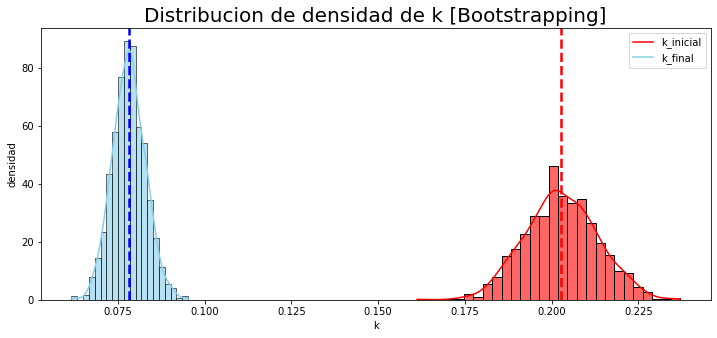

In [161]:
# Bootstrapping

datos_boots = bootstrap_simplificado(val_k,1000)
datos_boots1 = bootstrap_simplificado(val_k1,1000)
alpha = 1
medias = np.apply_along_axis(func1d=np.mean, axis=1, arr=datos_boots)
medias1 = np.apply_along_axis(func1d=np.mean, axis=1, arr=datos_boots1)
medias.sort()
k_final = medias.mean()
medias1.sort()
k1_final = medias1.mean()
proc_reduccion = (k1_final-k_final)/k_final
print(f"k_final={medias.mean()}")
print(f"k1_final={medias1.mean()}")
print(f"Proc_reduccion={proc_reduccion}")

plt.figure(figsize = (12,5))

sns.histplot(medias,color="red",stat = 'density', kde=True, alpha=0.6)
sns.histplot(medias1,bins=20,color="skyblue",stat = 'density', kde=True, alpha=0.6)
plt.axvline(x=medias.mean(),
            color='red',
            ls='--',  
            lw=2.5)  
plt.axvline(x=medias1.mean(),
            color='blue',
            ls='--',  
            lw=2.5)    
plt.title("Distribucion de densidad de k [Bootstrapping]", fontsize=20)
labels= ["k_inicial","k_final"]
plt.legend(labels,loc=0)
plt.xlabel("k")
plt.ylabel("densidad")

In [162]:
def scatter_linear_reg(X, labelx, Y,labely,invertir_y=False):

    linear_reg = LinearRegression()

    X_k = X.values.reshape(-1,1)
    y_k = Y.values.reshape(-1,1)

    linear_reg.fit(X_k,y_k)
    y_pred = linear_reg.predict(X_k)

    plt.figure(figsize = (12,5))
    plt.scatter(X, Y)
    plt.plot(X_k, y_pred, color="red")
    # labelx = "Valor de " + labelx 
    # labely = "Valor de " + labely
    plt.xlabel(labelx, fontsize=20)
    plt.ylabel(labely, fontsize=20)
    if invertir_y == True:
        plt.ylim(max(round(max(Y))*1.2,0),min(Y)*1.1)


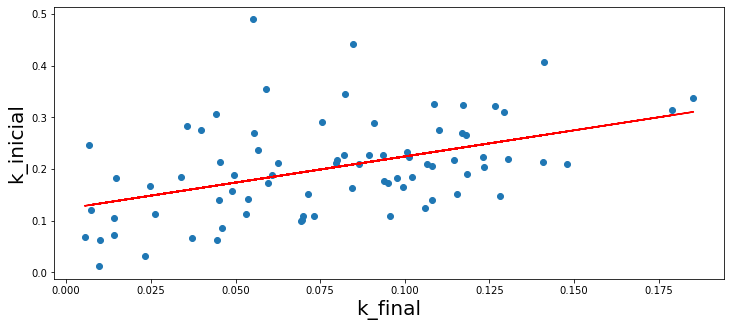

In [163]:
scatter_linear_reg(df_f3.k1, "k_final", df_f3.k ,"k_inicial")

Se puede observar aun leve correlación entre el valor de k_inicial y K_final.

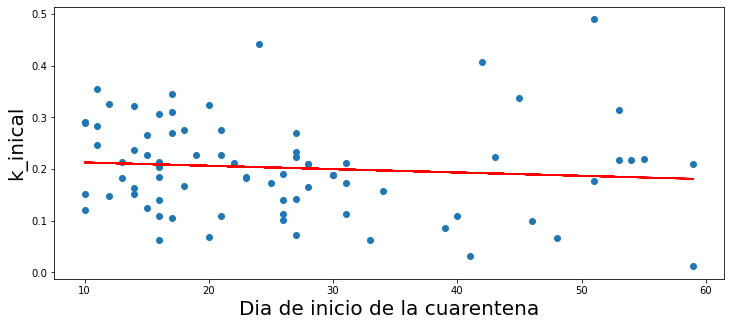

In [164]:
scatter_linear_reg(df_f3.t, "Dia de inicio de la cuarentena", df_f3.k ,"k_inical")


Podemos observar que al correr el inicio de la cuarentena respecto al primer contagio el valor de k_inicial tiene a una leve tendencia a ser menor. Esta reducción puede deberse a la implementación de otras medidas antes de aplicar la cuarentena. 

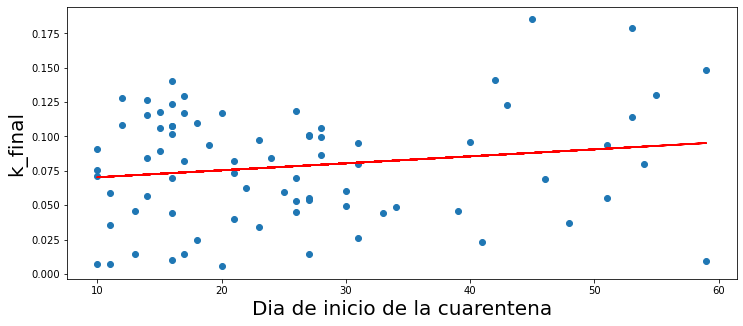

In [165]:
scatter_linear_reg(df_f3.t, "Dia de inicio de la cuarentena", df_f3.k1 ,"k_final")

Podemos observar que, al correr el inicio de la cuarentena, la K_final a diferencia del K_inical tiende a ser mayor. 

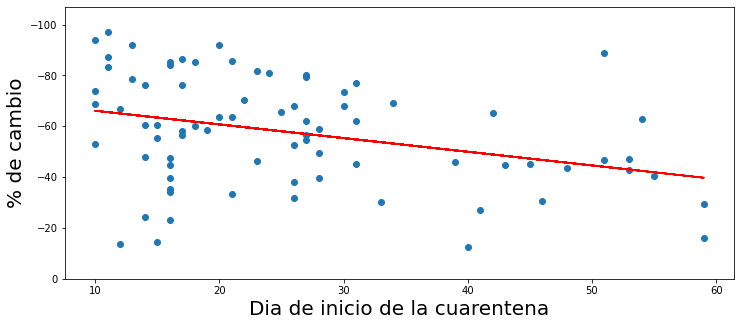

In [166]:
scatter_linear_reg(df_f3.t, "Dia de inicio de la cuarentena", df_f3["%D"]*100 ,"% de cambio",True)

Se confirma que aplazar el inicio de la cuarentene reduce la efectividad de esta.

Esto puede deberse, que al haber una mayor cantidad de casos activos al momento de iniciar la cuarentena sea más difícil reducir la propagación del virus

#### Conclusión

De fujo de trabajo propuesto se puede concluir que la aplicación de la pandemia tiene alta influencia en la reducción del valor de K. 

Además, se puede observar la importancia de aplicarla al inicio de la pandemia, ya que tiene una mayor efectividad. 

Otro punto para tomar en cuenta es que el valor promedio de K_inicial de los países estudiados es de da un valor muy cercano a obtenido al evaluar el k del mundo en la primera parte.

## Informe

### Primera Parte - ¿Como empezo la pandemia?

En esta instancia se propuso analizar 10 paises con sus respectivas ventanas de tiempo donde los contagios de Covid-19 estaban en una fase de crecimiento exponencial, por lo que la cantidad de casos confirmados puede aproximarse a la siguiente fórmula:
$C(t)=e^{k(t-t_0)}$

El valor de k esta relacionado con el tiempo en que una persona enferma contagia, el nivel de infecciosidad del virus, y por la circulacion de la gente. Una de las propuestas de este proyecto es ver efectivamente si este parametro k tiene relaciona con la aplicacion de la cuarentena, de forma de que este valor disminuya. Esto se analizó en la parte de "investigacion".

El siguiente desafio fue realizar un intervalo de confianza para el promedio de k de los 10 paises seleccionados, y con este tratar de predecir el k mundial. Se propuso el siguiente flujo de trabajo para cada pais: 

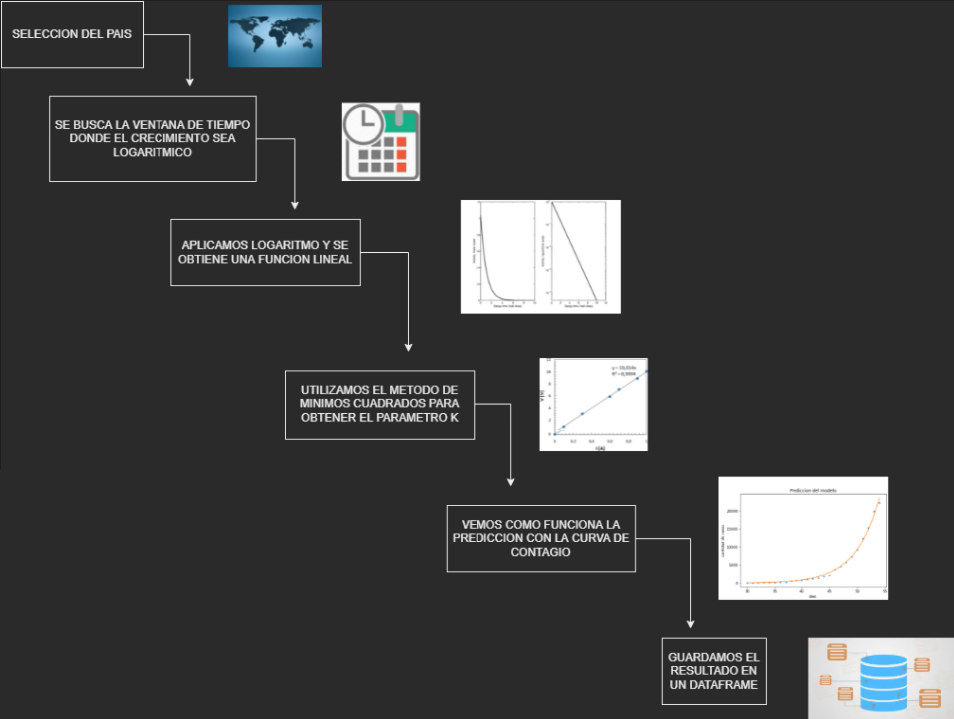

In [171]:
from IPython.display import Image
Image("flujo de trabajo.png")


Del flujo trabajo propuesto se seleccionar los sigientes paises:

['Australia', 'Austria', 'Czechia', 'Finland', 'Germany', 'Pakistan',
 'Portugal', 'Switzerland', 'Thailand', 'United Kingdom']

Dando un valor de k promedio de 0.2206. Por otro lado el valor de K mundial para el intervalo seleccionado dio un valor de 0.2202. esta similitud no deberian ser concluyente.

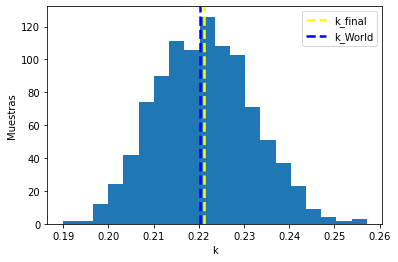

In [172]:
from IPython.display import Image
Image("K_final_vs_k_world.png")

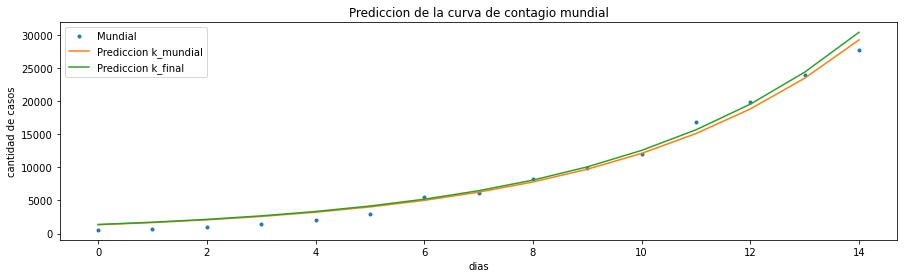

In [173]:
from IPython.display import Image
Image("Predicion_k_world.png")

### Segunda Parte - Evaluando Estrategias

En esta parte del proyecto en primer lugar se busca escoger una medida sanitaria, en este caso fue la cuarentena, y 3 indicadores que esten relacionados con el impacto que tiene esta medida. Los indicadores seleccionados fueron:

**new_cases_smoothed** = Nuevos casos de COVID-19 (Media movil de 7 dias). El contado incluye casos probables cuando son reportados.

**reproduction_rate** = Estimación en tiempo real del R (factor de reproduccion) efectivo del COVID-19

**stringency_index** = Indice de Rigurosidad de la Respuesta del Gobierno: es una medida compuesta basada en 9 indicadores que incluyen: cierres de escuelas, cierres de espacios de trabajo, prohibicion del transporte publico, etc. Esta reescalado a un valor entre 0 y 100, siendo 100 el valor de mas estricto.

Acerca de estos indicadores concluimos que no estaban correlacionados entre si, y cual fue la relevancia de cada uno para el modelo en funcion de su importancia. Esto lo vemos en los siguientes graficos:



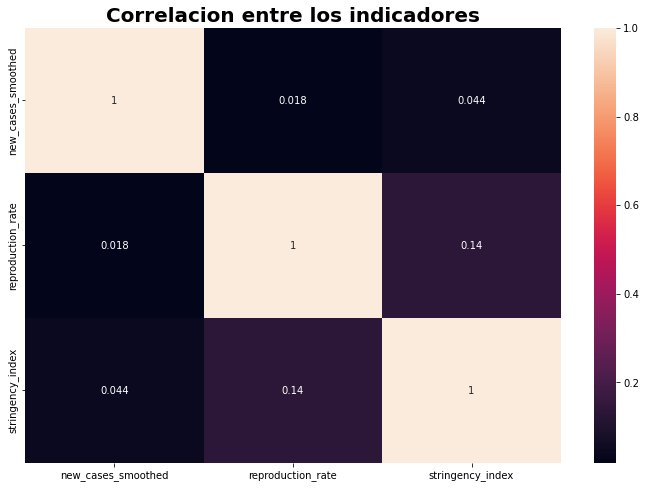

In [174]:
from IPython.display import Image
Image("correlacion.png")

El siguiente paso fue seleccionar 5 países que no hayan hecho cuarentena y 5 que si para luego construir un clasificador binario a partir de una regresión logística o Naive Bayes, que pueda predecir cuándo un país está haciendo o no cuarentena. Previamente a realizar el modelo para los 10 países a modo de ejemplo se probó el modelo para Argentina, dando una asertividad del 100% tanto para el train como para el test.

**Modelo 10 Paises**

Los paises que hicieron cuarentena seleccionados fueron: Argentina, Philippines, France, Ecuador y Lebanon

Los paises que NO hicieron cuarentena seleccionados fueron: Belarus, Armenia, Costa Rica, Denmark y Finland.

Los resultados para la Regresion Logistica en este caso fueron de una asertividad del 84.4% 

Los resultados para Naive Bayes en este caso fueron del 84.2%
![](conf_10p_bayes.jpeg)

en este caso la precision de ambos es relativamente buena, y vemos que la regresion logistica aparentemente es el clasificador que funciona mejor de los dos.


**Utilización del modelo para predecir paises nuevos**

Los países utilizados para predecir en que momentos habían hecho cuarentena fueron:

India, Chile, Germany, Sweden, Mexico, Russia, Thailand, Kazakhstan, Australia y Ukraine.

La precisión del modelo de regresión logística entrenado fue de ~ 81.4% y la del modelo de Naive Bayes de ~ 78.5. Con estos resultados podemos decir que el modelo de regresión logística entrenado con 5 países que hicieron cuarentena y 5 que no, puede hacer esta predicción con una precisión aceptable. confirmando que el modelo que mejor predice es la regresión logística.


### Investigacion

**¿Como funciona el modelo si lo probamos con todos los países del dataset?**

Al probar el modelo, con todos los países del mundo, se obtuvo una precisión de ~ 78,7% confirmando que el modelo entrenado con los 10 países en lo suficientemente robusto. 

**¿Existe una relación entre el promedio de dias que se hizo y no se hizo cuarentena, y el porcentaje de la población contagiada acumulada?**

Se observo una tendencia de que al realizar mayor tiempo de cuarentena el porcentaje de población contagiada es menor. validando así la importancia de esta medida para disminuir el valor de K.

**¿Como se ve afectado el valor K al momento de imponer al momento de imponer la cuarentena?**

Se determino que aplicar la cuarentena tiene una gran relevancia en reducir el valor de K en cada uno de los países evaluados, danto un promedio de reducción de un ~57.5%. validando lo observado al responder la pregunta anterior.

Además, se observó la importancia implementar la cuarentena lo más cercano a la fecha de confirmación del primer contagio 

# Fin